In [ ]:
!pip install joblib matplotlib numpy optuna pandas lightgbm xgboost catboost pytorch-tabnet scikit-learn

In [ ]:
import json
from functools import partial
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import pickle
import random
import torch

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, Pool, cv
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier, plot_importance

RANDOM_SEED = 67


In [ ]:
ARTIFACT_ROOT = Path("artifacts")


def ensure_dir(path: Path) -> Path:
    path.mkdir(parents=True, exist_ok=True)
    return path


def reshape_for_meta(array: np.ndarray) -> np.ndarray:
    array = np.asarray(array)
    if array.ndim == 1:
        return array.reshape(-1, 1)
    return array


def persist_model(model, destination: Path, model_name: str) -> Path:
    ensure_dir(destination.parent)
    if model_name == "lightgbm":
        file_path = destination.with_suffix(".txt")
        model.save_model(str(file_path))
    elif model_name == "catboost":
        file_path = destination.with_suffix(".cbm")
        model.save_model(str(file_path))
    elif model_name == "xgboost":
        file_path = destination.with_suffix(".json")
        model.save_model(str(file_path))
    elif model_name == "tabnet":
        base_path = str(destination)
        if base_path.endswith(".zip"):
            base_path = base_path[:-4]
        model.save_model(base_path)
        file_path = Path(f"{base_path}.zip")
    else:
        file_path = destination.with_suffix(".pkl")
        with open(file_path, "wb") as fp:
            pickle.dump(model, fp)
    return file_path


def lightgbm_predict_proba(model: lgb.Booster, data):
    best_iter = model.best_iteration or model.current_iteration()
    return model.predict(data, num_iteration=best_iter)


def compute_fold_sample_weight(y_values):
    return compute_sample_weight(class_weight="balanced", y=y_values)


In [ ]:
def train_catboost(X_train, X_val, y_train, y_val, params, fold, sample_weight=None):
    model_params = {**params}
    model_params.setdefault("loss_function", "MultiClass")
    model_params.setdefault("eval_metric", "MultiClass")
    if "task_type" not in model_params:
        model_params["task_type"] = "CPU"
    if model_params.get("task_type") == "GPU" and "devices" not in model_params:
        model_params["devices"] = "0"
    model_params.setdefault("verbose", 0)
    model_params["random_state"] = RANDOM_SEED + fold

    train_pool = Pool(X_train, y_train, weight=sample_weight)
    val_pool = Pool(X_val, y_val)

    model = CatBoostClassifier(**model_params)
    model.fit(
        train_pool,
        eval_set=val_pool,
        early_stopping_rounds=20,
        use_best_model=True,
        verbose=False,
    )

    val_proba = model.predict_proba(X_val)
    val_preds = np.argmax(val_proba, axis=1)
    accuracy = accuracy_score(y_val, val_preds)

    return model, val_proba, accuracy


In [ ]:
def train_lgb(X_train, X_val, y_train, y_val, params, fold, sample_weight=None, num_classes=3):
    model_params = {**params}
    model_params.setdefault("objective", "multiclass")
    model_params.setdefault("num_class", num_classes)
    model_params.setdefault("metric", "multi_logloss")
    model_params.setdefault("verbose", -1)
    model_params["seed"] = RANDOM_SEED + fold

    train_data = lgb.Dataset(X_train, label=y_train, weight=sample_weight)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    model = lgb.train(
        model_params,
        train_data,
        num_boost_round=200,
        valid_sets=[val_data],
        callbacks=[lgb.early_stopping(stopping_rounds=20), lgb.log_evaluation(period=0)]
    )

    val_proba = lightgbm_predict_proba(model, X_val)
    val_preds = np.argmax(val_proba, axis=1)
    accuracy = accuracy_score(y_val, val_preds)

    return model, val_proba, accuracy


In [ ]:
def train_xgb(X_train, X_val, y_train, y_val, params, fold, sample_weight=None, num_classes=3):
    model_params = {**params}
    model_params.setdefault("objective", "multi:softprob")
    model_params.setdefault("num_class", num_classes)
    model_params.setdefault("eval_metric", "mlogloss")
    model_params.setdefault("verbosity", 0)
    model_params["random_state"] = RANDOM_SEED + fold
    model_params["use_label_encoder"] = False
    model_params["early_stopping_rounds"] = 20

    model = XGBClassifier(**model_params)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        sample_weight=sample_weight,
        verbose=False,
    )

    val_proba = model.predict_proba(X_val)
    val_preds = np.argmax(val_proba, axis=1)
    accuracy = accuracy_score(y_val, val_preds)

    return model, val_proba, accuracy


In [ ]:
def train_tabnet(X_train, X_val, y_train, y_val, params, fold, sample_weight=None):
    model_params = params.copy()
    lr = model_params.pop("lr", 0.01)

    model_params["optimizer_fn"] = torch.optim.AdamW
    model_params["optimizer_params"] = dict(lr=lr)
    model_params.setdefault("verbose", 0)

    model = TabNetClassifier(**model_params)

    model.fit(
        X_train.values,
        y_train,
        eval_set=[(X_val.values, y_val)],
        eval_name=["valid"],
        eval_metric=["logloss"],
        max_epochs=200,
        patience=20,
        batch_size=1024,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
        weights=sample_weight,
        from_unsupervised=None,
    )

    val_proba = model.predict_proba(X_val.values)
    val_pred = np.argmax(val_proba, axis=1)
    accuracy = accuracy_score(y_val, val_pred)

    return model, val_proba, accuracy


In [ ]:
def objective_catboost(trial, X, y, n_splits=5, random_seed=RANDOM_SEED):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 500),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "task_type": trial.suggest_categorical("task_type", ["CPU", "GPU"]),
        "loss_function": "MultiClass",
        "eval_metric": "MultiClass",
        "random_seed": random_seed,
        "verbose": 0,
    }
    if params["task_type"] == "GPU":
        params["devices"] = "0"

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    accuracies = []

    for train_idx, valid_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[valid_idx]
        train_weights = compute_fold_sample_weight(y_train)

        model = CatBoostClassifier(**params)
        model.fit(
            X_train,
            y_train,
            sample_weight=train_weights,
            eval_set=(X_val, y_val),
            early_stopping_rounds=20,
            verbose=False,
        )
        preds = model.predict(X_val)
        accuracies.append(accuracy_score(y_val, preds))

    return float(np.mean(accuracies))


In [ ]:
def objective_lgb(trial, X, y, num_classes, n_splits=5, random_seed=RANDOM_SEED):
    params = {
        "objective": "multiclass",
        "num_class": num_classes,
        "metric": "multi_logloss",
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 16, 128),
        "max_depth": trial.suggest_int("max_depth", -1, 15),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "verbose": -1,
        "seed": random_seed,
    }

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    accuracies = []

    for train_idx, valid_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[valid_idx]
        train_weights = compute_fold_sample_weight(y_train)

        train_data = lgb.Dataset(X_train, label=y_train, weight=train_weights)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
        model = lgb.train(
            params,
            train_data,
            valid_sets=[val_data],
            callbacks=[lgb.early_stopping(stopping_rounds=20), lgb.log_evaluation(period=0)]
        )

        preds = np.argmax(lightgbm_predict_proba(model, X_val), axis=1)
        accuracies.append(accuracy_score(y_val, preds))

    return float(np.mean(accuracies))


In [ ]:
def objective_xgb(trial, X, y, num_classes, n_splits=5, random_seed=RANDOM_SEED):
    params = {
        "objective": "multi:softprob",
        "num_class": num_classes,
        "eval_metric": "mlogloss",
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "random_state": random_seed,
        "verbosity": 0,
        "use_label_encoder": False,
    }

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    accuracies = []

    for train_idx, valid_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[valid_idx]
        train_weights = compute_fold_sample_weight(y_train)

        model = XGBClassifier(**params)
        model.fit(
            X_train,
            y_train,
            sample_weight=train_weights,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=20,
            verbose=False,
        )
        preds = model.predict(X_val)
        accuracies.append(accuracy_score(y_val, preds))

    return float(np.mean(accuracies))


In [ ]:
def objective_tabnet(trial, X, y, n_splits=5, random_seed=42):
    optimizer_name = trial.suggest_categorical("optimizer_fn", ["adam", "adamw"])

    optimizer_map = {
        "adam": torch.optim.Adam,
        "adamw": torch.optim.AdamW,
    }

    params = {
        "n_d": trial.suggest_int("n_d", 8, 64, step=8),
        "n_a": trial.suggest_int("n_a", 8, 64, step=8),
        "n_steps": trial.suggest_int("n_steps", 3, 10),
        "gamma": trial.suggest_float("gamma", 1.0, 2.0, step=0.1),
        "lambda_sparse": trial.suggest_float("lambda_sparse", 1e-6, 1e-3, log=True),
        "optimizer_fn": optimizer_map[optimizer_name],
        "optimizer_params": {"lr": trial.suggest_float("lr", 1e-4, 1e-2, log=True)},
        "momentum": trial.suggest_float("momentum", 0.01, 0.4),
        "seed": random_seed,
        "verbose": 0,
    }

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    accuracies = []

    for train_idx, valid_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[valid_idx]
        train_weights = compute_fold_sample_weight(y_train)

        model = TabNetClassifier(**params)

        model.fit(
            X_train.values,
            y_train.values,
            eval_set=[(X_val.values, y_val.values)],
            eval_metric=["accuracy"],
            max_epochs=200,
            patience=2,
            batch_size=1024,
            virtual_batch_size=128,
            weights=train_weights,
        )

        preds = model.predict(X_val.values)
        accuracies.append(accuracy_score(y_val, preds))

    return float(np.mean(accuracies))


In [ ]:
def run_stacking_pipeline(
    X,
    y,
    *,
    test_size=0.2,
    n_trials=30,
    base_cv_splits=10,
    optuna_cv_splits=5,
    artifact_root: Path = ARTIFACT_ROOT,
    random_seed: int = RANDOM_SEED,
):
    if not isinstance(X, pd.DataFrame):
        X_df = pd.DataFrame(X)
    else:
        X_df = X.copy()

    if isinstance(y, pd.DataFrame):
        if y.shape[1] != 1:
            raise ValueError("y must be a 1-D vector.")
        y_series = y.iloc[:, 0].copy()
    elif isinstance(y, pd.Series):
        y_series = y.copy()
    else:
        y_series = pd.Series(y)

    if X_df.shape[0] != len(y_series):
        raise ValueError("X and y must have the same number of rows.")
    if len(np.unique(y_series)) < 2:
        raise ValueError("y must contain at least two classes.")

    np.random.seed(random_seed)
    artifact_root = ensure_dir(Path(artifact_root))

    X_train, X_test, y_train, y_test = train_test_split(
        X_df,
        y_series,
        test_size=test_size,
        stratify=y_series,
        random_state=random_seed,
    )

    num_classes = len(np.unique(y_train))

    objective_wrappers = {
        "catboost": partial(
            objective_catboost,
            X=X_train,
            y=y_train,
            n_splits=optuna_cv_splits,
            random_seed=random_seed,
        ),
        "lightgbm": partial(
            objective_lgb,
            X=X_train,
            y=y_train,
            num_classes=num_classes,
            n_splits=optuna_cv_splits,
            random_seed=random_seed,
        ),
        "xgboost": partial(
            objective_xgb,
            X=X_train,
            y=y_train,
            num_classes=num_classes,
            n_splits=optuna_cv_splits,
            random_seed=random_seed,
        ),
        "tabnet": partial(
            objective_tabnet,
            X=X_train,
            y=y_train,
            n_splits=optuna_cv_splits,
            random_seed=random_seed,
        ),
    }

    best_params = {}
    for model_name, objective_fn in objective_wrappers.items():
        study = optuna.create_study(direction="maximize")
        study.optimize(objective_fn, n_trials=n_trials)
        best_params[model_name] = study.best_params
        print(f"{model_name.title()} best params: {study.best_params}")

    with open(artifact_root / "best_params.json", "w", encoding="utf-8") as fp:
        json.dump(best_params, fp, indent=2)

    skf = StratifiedKFold(n_splits=base_cv_splits, shuffle=True, random_state=random_seed)

    oof_predictions = {
        "catboost": np.zeros((len(y_train), num_classes)),
        "lightgbm": np.zeros((len(y_train), num_classes)),
        "xgboost": np.zeros((len(y_train), num_classes)),
        "tabnet": np.zeros((len(y_train), num_classes)),
    }
    test_predictions = {
        "catboost": np.zeros((len(y_test), num_classes)),
        "lightgbm": np.zeros((len(y_test), num_classes)),
        "xgboost": np.zeros((len(y_test), num_classes)),
        "tabnet": np.zeros((len(y_test), num_classes)),
    }
    fold_accuracies = {model: [] for model in oof_predictions}
    saved_model_paths = {model: [] for model in oof_predictions}

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), start=1):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        train_weights = compute_fold_sample_weight(y_tr)

        cb_model, cb_val_proba, cb_acc = train_catboost(
            X_tr,
            X_val,
            y_tr,
            y_val,
            params=best_params["catboost"],
            fold=fold,
            sample_weight=train_weights,
        )
        oof_predictions["catboost"][val_idx] = cb_val_proba
        test_predictions["catboost"] += cb_model.predict_proba(X_test)
        fold_accuracies["catboost"].append(cb_acc)
        saved_model_paths["catboost"].append(
            str(persist_model(cb_model, artifact_root / "catboost" / f"fold_{fold}", "catboost"))
        )

        lgb_model, lgb_val_proba, lgb_acc = train_lgb(
            X_tr,
            X_val,
            y_tr,
            y_val,
            params=best_params["lightgbm"],
            fold=fold,
            sample_weight=train_weights,
            num_classes=num_classes,
        )
        oof_predictions["lightgbm"][val_idx] = lgb_val_proba
        test_predictions["lightgbm"] += lightgbm_predict_proba(lgb_model, X_test)
        fold_accuracies["lightgbm"].append(lgb_acc)
        saved_model_paths["lightgbm"].append(
            str(persist_model(lgb_model, artifact_root / "lightgbm" / f"fold_{fold}", "lightgbm"))
        )

        xgb_model, xgb_val_proba, xgb_acc = train_xgb(
            X_tr,
            X_val,
            y_tr,
            y_val,
            params=best_params["xgboost"],
            fold=fold,
            sample_weight=train_weights,
            num_classes=num_classes,
        )
        oof_predictions["xgboost"][val_idx] = xgb_val_proba
        test_predictions["xgboost"] += xgb_model.predict_proba(X_test)
        fold_accuracies["xgboost"].append(xgb_acc)
        saved_model_paths["xgboost"].append(
            str(persist_model(xgb_model, artifact_root / "xgboost" / f"fold_{fold}", "xgboost"))
        )

        tabnet_model, tabnet_val_proba, tabnet_acc = train_tabnet(
            X_tr,
            X_val,
            y_tr,
            y_val,
            params=best_params["tabnet"],
            fold=fold,
            sample_weight=train_weights,
        )
        oof_predictions["tabnet"][val_idx] = tabnet_val_proba
        test_predictions["tabnet"] += tabnet_model.predict_proba(X_test.values)
        fold_accuracies["tabnet"].append(tabnet_acc)
        saved_model_paths["tabnet"].append(
            str(persist_model(tabnet_model, artifact_root / "tabnet" / f"fold_{fold}", "tabnet"))
        )

        print(f"Fold {fold} complete.")

    for model_name in test_predictions:
        test_predictions[model_name] /= base_cv_splits

    meta_features_train = np.hstack([reshape_for_meta(oof_predictions[name]) for name in oof_predictions])
    meta_features_test = np.hstack([reshape_for_meta(test_predictions[name]) for name in test_predictions])

    meta_model = LogisticRegressionCV(
        cv=base_cv_splits,
        multi_class="multinomial",
        max_iter=1000,
        class_weight="balanced",
        random_state=random_seed,
    )
    meta_model.fit(meta_features_train, y_train)

    meta_train_preds = meta_model.predict(meta_features_train)
    meta_train_acc = accuracy_score(y_train, meta_train_preds)

    meta_test_preds = meta_model.predict(meta_features_test)
    meta_test_acc = accuracy_score(y_test, meta_test_preds)
    meta_test_proba = meta_model.predict_proba(meta_features_test)
    meta_report = classification_report(y_test, meta_test_preds, digits=4)

    meta_model_path = artifact_root / "meta_model.joblib"
    joblib.dump(meta_model, meta_model_path)

    predictions_df = pd.DataFrame(
        {
            "y_true": y_test.values,
            "y_pred": meta_test_preds,
        }
    )
    predictions_path = artifact_root / "meta_model_test_predictions.csv"
    predictions_df.to_csv(predictions_path, index=False)

    np.save(artifact_root / "meta_features_train.npy", meta_features_train)
    np.save(artifact_root / "meta_features_test.npy", meta_features_test)
    np.save(artifact_root / "meta_test_proba.npy", meta_test_proba)

    summary = {
        "best_params": best_params,
        "fold_metrics": {
            name: {
                "mean_accuracy": float(np.mean(scores)),
                "std_accuracy": float(np.std(scores)),
            }
            for name, scores in fold_accuracies.items()
        },
        "meta_train_accuracy": float(meta_train_acc),
        "meta_test_accuracy": float(meta_test_acc),
        "classification_report": meta_report,
        "saved_models": saved_model_paths,
        "meta_model_path": str(meta_model_path),
        "test_predictions_path": str(predictions_path),
    }

    return summary


In [ ]:
data_path = Path("/kaggle/input/nasa-dataset-tryhard/combined_imputed_values.csv")

if data_path.exists():
    df = pd.read_csv(data_path)
    if "disposition" not in df.columns:
        raise KeyError("Column 'disposition' is missing from the dataset.")
    X = df.drop(columns=["disposition"])
    y = df["disposition"]
    print(f"Loaded dataset with shape {df.shape}.")
else:
    print("Dataset 'combined_imputed_values.csv' not found. Define X and y manually.")


Loaded dataset with shape (16707, 11).


In [ ]:
if "X" in globals() and "y" in globals():
    le = LabelEncoder()
    y_fixed = le.fit_transform(y)

    pipeline_results = run_stacking_pipeline(
        X,
        y_fixed,
        test_size=0.2,
        n_trials=30,
        base_cv_splits=10,
        optuna_cv_splits=5,
        artifact_root=ARTIFACT_ROOT,
        random_seed=RANDOM_SEED,
    )
    pipeline_results
else:
    print("Define X (features) and y (target) before running the stacking pipeline.")


[I 2025-10-05 13:49:16,631] A new study created in memory with name: no-name-6e701a15-e76c-4b6f-a31d-8dc36c4d06b4
[I 2025-10-05 13:50:46,470] Trial 0 finished with value: 0.6653946876169099 and parameters: {'iterations': 355, 'depth': 10, 'learning_rate': 0.0024532659838875153, 'l2_leaf_reg': 4.51014652973924, 'task_type': 'CPU'}. Best is trial 0 with value: 0.6653946876169099.
[I 2025-10-05 13:50:53,078] Trial 1 finished with value: 0.710362888140666 and parameters: {'iterations': 385, 'depth': 4, 'learning_rate': 0.1314836689646944, 'l2_leaf_reg': 2.45306209906101, 'task_type': 'CPU'}. Best is trial 1 with value: 0.710362888140666.
[I 2025-10-05 13:51:11,460] Trial 2 finished with value: 0.7187429854096521 and parameters: {'iterations': 392, 'depth': 7, 'learning_rate': 0.08991434499963259, 'l2_leaf_reg': 1.2101078616877543, 'task_type': 'CPU'}. Best is trial 2 with value: 0.7187429854096521.
[I 2025-10-05 13:51:24,274] Trial 3 finished with value: 0.7155256266367378 and parameters: 

Catboost best params: {'iterations': 392, 'depth': 7, 'learning_rate': 0.08991434499963259, 'l2_leaf_reg': 1.2101078616877543, 'task_type': 'CPU'}
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.976938
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.979459
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.97342
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.973994
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 13:59:42,368] Trial 0 finished with value: 0.691956603067714 and parameters: {'learning_rate': 0.0022006801062677715, 'num_leaves': 96, 'max_depth': 9, 'min_child_samples': 27, 'subsample': 0.6231638064093534, 'colsample_bytree': 0.8046562153314318}. Best is trial 0 with value: 0.691956603067714.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.977453
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.947646
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.952063
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.944289
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.945562
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 13:59:45,437] Trial 1 finished with value: 0.6823045267489711 and parameters: {'learning_rate': 0.0031211423524070935, 'num_leaves': 58, 'max_depth': 7, 'min_child_samples': 24, 'subsample': 0.8947188223021196, 'colsample_bytree': 0.8290538150308777}. Best is trial 0 with value: 0.691956603067714.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.950296
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.947708
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.951837
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.943478
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.944466
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 13:59:48,109] Trial 2 finished with value: 0.6768424990647214 and parameters: {'learning_rate': 0.003468356036397931, 'num_leaves': 54, 'max_depth': 6, 'min_child_samples': 8, 'subsample': 0.9991780340509847, 'colsample_bytree': 0.6660986002060226}. Best is trial 0 with value: 0.691956603067714.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.949537
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.882618
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.894896
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.874996
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.87942
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 13:59:48,728] Trial 3 finished with value: 0.630976430976431 and parameters: {'learning_rate': 0.02611338168473773, 'num_leaves': 65, 'max_depth': 1, 'min_child_samples': 18, 'subsample': 0.6385486027018249, 'colsample_bytree': 0.7016125645707847}. Best is trial 0 with value: 0.691956603067714.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.888007
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.772123
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.782709
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.758392
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.761253
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 13:59:50,429] Trial 4 finished with value: 0.6794612794612795 and parameters: {'learning_rate': 0.01817934731733713, 'num_leaves': 29, 'max_depth': 5, 'min_child_samples': 47, 'subsample': 0.7606999898785616, 'colsample_bytree': 0.5625830116728434}. Best is trial 0 with value: 0.691956603067714.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.77919
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.902045
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.907384
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.897994
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.898424
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 13:59:53,762] Trial 5 finished with value: 0.6983164983164982 and parameters: {'learning_rate': 0.004253202238271349, 'num_leaves': 49, 'max_depth': 15, 'min_child_samples': 43, 'subsample': 0.854401558421046, 'colsample_bytree': 0.8008407552803691}. Best is trial 5 with value: 0.6983164983164982.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.905119
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.02543
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.02712
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.0232
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.0241
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 13:59:56,247] Trial 6 finished with value: 0.6845491956603068 and parameters: {'learning_rate': 0.0012787954496670524, 'num_leaves': 28, 'max_depth': 12, 'min_child_samples': 24, 'subsample': 0.6808206321795571, 'colsample_bytree': 0.8609833948942991}. Best is trial 5 with value: 0.6983164983164982.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.02628
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.666363
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.682283
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.649827
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.650321
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 14:00:00,558] Trial 7 finished with value: 0.7150766928544706 and parameters: {'learning_rate': 0.030296239601163715, 'num_leaves': 75, 'max_depth': 15, 'min_child_samples': 24, 'subsample': 0.8207048238208814, 'colsample_bytree': 0.6826113245572221}. Best is trial 7 with value: 0.7150766928544706.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.674803
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.807632
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.818594
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.800852
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.801337
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 14:00:02,938] Trial 8 finished with value: 0.693677515899738 and parameters: {'learning_rate': 0.009023925774491215, 'num_leaves': 26, 'max_depth': 0, 'min_child_samples': 44, 'subsample': 0.5530185293379293, 'colsample_bytree': 0.8920630953383719}. Best is trial 7 with value: 0.7150766928544706.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.815119
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.03709
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.03883
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.03547
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.03576
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 14:00:04,743] Trial 9 finished with value: 0.6653946876169099 and parameters: {'learning_rate': 0.0012581631852242661, 'num_leaves': 96, 'max_depth': 5, 'min_child_samples': 33, 'subsample': 0.6289884403432817, 'colsample_bytree': 0.7419166077538726}. Best is trial 7 with value: 0.7150766928544706.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.03811
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 0.662597
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.675318
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[39]	valid_0's multi_logloss: 0.634554
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[32]	valid_0's multi_logloss: 0.644125
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 14:00:08,435] Trial 10 finished with value: 0.7166479610924055 and parameters: {'learning_rate': 0.13600201103467963, 'num_leaves': 128, 'max_depth': 15, 'min_child_samples': 6, 'subsample': 0.7971737046183693, 'colsample_bytree': 0.981950187311476}. Best is trial 10 with value: 0.7166479610924055.


Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.667417
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[28]	valid_0's multi_logloss: 0.666798
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 0.676607
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[28]	valid_0's multi_logloss: 0.634732
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[30]	valid_0's multi_logloss: 0.648407
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 14:00:11,637] Trial 11 finished with value: 0.7170220725776281 and parameters: {'learning_rate': 0.16078483991146564, 'num_leaves': 126, 'max_depth': 14, 'min_child_samples': 8, 'subsample': 0.8099008361810739, 'colsample_bytree': 0.9859785778638701}. Best is trial 11 with value: 0.7170220725776281.


Early stopping, best iteration is:
[30]	valid_0's multi_logloss: 0.670268
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 0.669477
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 0.680897
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 0.648465
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 0.655127
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 14:00:13,901] Trial 12 finished with value: 0.7140291806958474 and parameters: {'learning_rate': 0.22699937852716376, 'num_leaves': 119, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.7381330504370306, 'colsample_bytree': 0.9722983149533473}. Best is trial 11 with value: 0.7170220725776281.


Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 0.675982
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[16]	valid_0's multi_logloss: 0.671185
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 0.684941
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[19]	valid_0's multi_logloss: 0.646441
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[16]	valid_0's multi_logloss: 0.65169
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 14:00:16,130] Trial 13 finished with value: 0.7164983164983164 and parameters: {'learning_rate': 0.24371898066831263, 'num_leaves': 128, 'max_depth': 12, 'min_child_samples': 14, 'subsample': 0.9307416374727884, 'colsample_bytree': 0.9978438316966571}. Best is trial 11 with value: 0.7170220725776281.


Early stopping, best iteration is:
[20]	valid_0's multi_logloss: 0.675718
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 0.659737
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[72]	valid_0's multi_logloss: 0.677047
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.631235
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[70]	valid_0's multi_logloss: 0.639893
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 14:00:21,098] Trial 14 finished with value: 0.7156752712308267 and parameters: {'learning_rate': 0.0735746129897958, 'num_leaves': 109, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.7736583358122644, 'colsample_bytree': 0.913808557706604}. Best is trial 11 with value: 0.7170220725776281.


Early stopping, best iteration is:
[74]	valid_0's multi_logloss: 0.673177
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	valid_0's multi_logloss: 0.65626
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 0.670198
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 0.630488
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[49]	valid_0's multi_logloss: 0.639939
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 14:00:25,167] Trial 15 finished with value: 0.7186681631126076 and parameters: {'learning_rate': 0.09030686629439792, 'num_leaves': 103, 'max_depth': 15, 'min_child_samples': 14, 'subsample': 0.8230691865313224, 'colsample_bytree': 0.9354337015163324}. Best is trial 15 with value: 0.7186681631126076.


Early stopping, best iteration is:
[58]	valid_0's multi_logloss: 0.660726
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[69]	valid_0's multi_logloss: 0.652459
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.668875
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's multi_logloss: 0.633068
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.635965
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 14:00:30,045] Trial 16 finished with value: 0.7193415637860083 and parameters: {'learning_rate': 0.06505896291138137, 'num_leaves': 92, 'max_depth': 13, 'min_child_samples': 15, 'subsample': 0.7127855318570496, 'colsample_bytree': 0.9219700265490746}. Best is trial 16 with value: 0.7193415637860083.


Did not meet early stopping. Best iteration is:
[94]	valid_0's multi_logloss: 0.65885
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[90]	valid_0's multi_logloss: 0.657795
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.676782
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.633232
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[85]	valid_0's multi_logloss: 0.638277
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 14:00:34,530] Trial 17 finished with value: 0.7172465394687617 and parameters: {'learning_rate': 0.05992054491865934, 'num_leaves': 87, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.7048394928419278, 'colsample_bytree': 0.9222319331149121}. Best is trial 16 with value: 0.7193415637860083.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.662549
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.655391
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.67283
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.630605
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.636111
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 14:00:38,542] Trial 18 finished with value: 0.7158997381219604 and parameters: {'learning_rate': 0.05657059243702528, 'num_leaves': 79, 'max_depth': 13, 'min_child_samples': 34, 'subsample': 0.5705270447458335, 'colsample_bytree': 0.5976607861907092}. Best is trial 16 with value: 0.7193415637860083.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.660611
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.710919
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.712933
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.686699
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.693934
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 14:00:39,624] Trial 19 finished with value: 0.6909090909090909 and parameters: {'learning_rate': 0.10693226480844274, 'num_leaves': 107, 'max_depth': 3, 'min_child_samples': 16, 'subsample': 0.8794679694313383, 'colsample_bytree': 0.9315107036320112}. Best is trial 16 with value: 0.7193415637860083.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.710757
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.781764
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.791176
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.772047
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.775791
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 14:00:43,968] Trial 20 finished with value: 0.6969696969696969 and parameters: {'learning_rate': 0.010207437388762189, 'num_leaves': 90, 'max_depth': 8, 'min_child_samples': 19, 'subsample': 0.7087241535461397, 'colsample_bytree': 0.7596674007048965}. Best is trial 16 with value: 0.7193415637860083.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.784294
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.657148
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.672428
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.634344
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.637334
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 14:00:48,806] Trial 21 finished with value: 0.7174710063598952 and parameters: {'learning_rate': 0.04691416396430851, 'num_leaves': 89, 'max_depth': 10, 'min_child_samples': 13, 'subsample': 0.6904492520078291, 'colsample_bytree': 0.8753312098634741}. Best is trial 16 with value: 0.7193415637860083.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.666904
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.661588
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.671851
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.635259
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.641357
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 14:00:54,700] Trial 22 finished with value: 0.716423494201272 and parameters: {'learning_rate': 0.04059570684947272, 'num_leaves': 112, 'max_depth': 11, 'min_child_samples': 12, 'subsample': 0.6671091538288089, 'colsample_bytree': 0.8732221753376948}. Best is trial 16 with value: 0.7193415637860083.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.665871
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[61]	valid_0's multi_logloss: 0.658235
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[52]	valid_0's multi_logloss: 0.670697
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[67]	valid_0's multi_logloss: 0.632747
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	valid_0's multi_logloss: 0.63376
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 14:00:59,015] Trial 23 finished with value: 0.7199401421623643 and parameters: {'learning_rate': 0.09002852585973696, 'num_leaves': 101, 'max_depth': 13, 'min_child_samples': 11, 'subsample': 0.5052169565081651, 'colsample_bytree': 0.946148461032672}. Best is trial 23 with value: 0.7199401421623643.


Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.66351
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[60]	valid_0's multi_logloss: 0.658223
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[45]	valid_0's multi_logloss: 0.675078
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 0.637951
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[80]	valid_0's multi_logloss: 0.638606
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 14:01:03,316] Trial 24 finished with value: 0.7168724279835391 and parameters: {'learning_rate': 0.09576108027942803, 'num_leaves': 101, 'max_depth': 13, 'min_child_samples': 20, 'subsample': 0.5124072093653183, 'colsample_bytree': 0.9533006153297577}. Best is trial 23 with value: 0.7199401421623643.


Early stopping, best iteration is:
[60]	valid_0's multi_logloss: 0.663779
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 0.669054
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 0.687983
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[15]	valid_0's multi_logloss: 0.642378
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 0.650839
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 14:01:04,907] Trial 25 finished with value: 0.7130564908342686 and parameters: {'learning_rate': 0.2898843329731681, 'num_leaves': 82, 'max_depth': 14, 'min_child_samples': 11, 'subsample': 0.5073503530923722, 'colsample_bytree': 0.8349672394684652}. Best is trial 23 with value: 0.7199401421623643.


Early stopping, best iteration is:
[17]	valid_0's multi_logloss: 0.674044
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 0.6666
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[28]	valid_0's multi_logloss: 0.67781
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 0.641093
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[25]	valid_0's multi_logloss: 0.641547
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 14:01:07,560] Trial 26 finished with value: 0.714552936775159 and parameters: {'learning_rate': 0.17021295122982516, 'num_leaves': 115, 'max_depth': 13, 'min_child_samples': 32, 'subsample': 0.588002322077332, 'colsample_bytree': 0.9360898192240683}. Best is trial 23 with value: 0.7199401421623643.


Early stopping, best iteration is:
[34]	valid_0's multi_logloss: 0.670164
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 0.656014
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[41]	valid_0's multi_logloss: 0.671718
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[68]	valid_0's multi_logloss: 0.631928
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[54]	valid_0's multi_logloss: 0.636428
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 14:01:11,602] Trial 27 finished with value: 0.7190422745978301 and parameters: {'learning_rate': 0.0952586585471592, 'num_leaves': 102, 'max_depth': 14, 'min_child_samples': 10, 'subsample': 0.9481363088019739, 'colsample_bytree': 0.9085890291509526}. Best is trial 23 with value: 0.7199401421623643.


Early stopping, best iteration is:
[48]	valid_0's multi_logloss: 0.663905
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.665553
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.682095
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.644288
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.649728
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 14:01:15,645] Trial 28 finished with value: 0.7153011597456043 and parameters: {'learning_rate': 0.03393893909529125, 'num_leaves': 68, 'max_depth': 11, 'min_child_samples': 10, 'subsample': 0.998230693675868, 'colsample_bytree': 0.7692549041626741}. Best is trial 23 with value: 0.7199401421623643.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.672935
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.707712
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.719604
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.692424
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.696375
Training until validation scores don't improve for 20 rounds


[I 2025-10-05 14:01:20,023] Trial 29 finished with value: 0.7002618780396558 and parameters: {'learning_rate': 0.020428332292145298, 'num_leaves': 98, 'max_depth': 8, 'min_child_samples': 21, 'subsample': 0.9265815786163453, 'colsample_bytree': 0.8355281051213619}. Best is trial 23 with value: 0.7199401421623643.
[I 2025-10-05 14:01:20,024] A new study created in memory with name: no-name-162a83a4-4af4-44bc-b39d-f2e1481fc395


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.714406
Lightgbm best params: {'learning_rate': 0.09002852585973696, 'num_leaves': 101, 'max_depth': 13, 'min_child_samples': 11, 'subsample': 0.5052169565081651, 'colsample_bytree': 0.946148461032672}


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se

Xgboost best params: {'learning_rate': 0.06636389168003629, 'max_depth': 9, 'subsample': 0.7078912825602846, 'colsample_bytree': 0.8332943451933689, 'n_estimators': 143}

Early stopping occurred at epoch 9 with best_epoch = 7 and best_val_0_accuracy = 0.61691


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 14 and best_val_0_accuracy = 0.6401


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 16 and best_val_0_accuracy = 0.65881


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 23 and best_val_0_accuracy = 0.6734


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 8 with best_epoch = 6 and best_val_0_accuracy = 0.59671


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 14:06:04,990] Trial 0 finished with value: 0.637186681631126 and parameters: {'optimizer_fn': 'adamw', 'n_d': 40, 'n_a': 48, 'n_steps': 4, 'gamma': 1.2, 'lambda_sparse': 0.00016714790849575278, 'lr': 0.0013928813833889583, 'momentum': 0.1339895879014632}. Best is trial 0 with value: 0.637186681631126.



Early stopping occurred at epoch 19 with best_epoch = 17 and best_val_0_accuracy = 0.61354


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 12 and best_val_0_accuracy = 0.58773


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 9 with best_epoch = 7 and best_val_0_accuracy = 0.58212


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 14 and best_val_0_accuracy = 0.61691


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 13 and best_val_0_accuracy = 0.60344


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 14:07:07,759] Trial 1 finished with value: 0.6007482229704452 and parameters: {'optimizer_fn': 'adam', 'n_d': 56, 'n_a': 56, 'n_steps': 6, 'gamma': 1.5, 'lambda_sparse': 2.1488457665528807e-06, 'lr': 0.0009908349243373479, 'momentum': 0.1324591047989748}. Best is trial 0 with value: 0.637186681631126.



Early stopping occurred at epoch 11 with best_epoch = 9 and best_val_0_accuracy = 0.60681


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 9 and best_val_0_accuracy = 0.57651


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 16 and best_val_0_accuracy = 0.62851


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 8 and best_val_0_accuracy = 0.578


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 8 and best_val_0_accuracy = 0.55181


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 14:07:46,515] Trial 2 finished with value: 0.5883277216610551 and parameters: {'optimizer_fn': 'adam', 'n_d': 16, 'n_a': 32, 'n_steps': 4, 'gamma': 1.6, 'lambda_sparse': 1.422311801627111e-06, 'lr': 0.0008403492303246837, 'momentum': 0.29280818240498796}. Best is trial 0 with value: 0.637186681631126.



Early stopping occurred at epoch 5 with best_epoch = 3 and best_val_0_accuracy = 0.38496


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 8 with best_epoch = 6 and best_val_0_accuracy = 0.38234


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 9 with best_epoch = 7 and best_val_0_accuracy = 0.37636


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 8 with best_epoch = 6 and best_val_0_accuracy = 0.38421


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 4 with best_epoch = 2 and best_val_0_accuracy = 0.37


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 14:08:10,480] Trial 3 finished with value: 0.37957351290684627 and parameters: {'optimizer_fn': 'adamw', 'n_d': 40, 'n_a': 24, 'n_steps': 4, 'gamma': 1.9, 'lambda_sparse': 8.019620927617014e-05, 'lr': 0.00012810922521064842, 'momentum': 0.2795701412286074}. Best is trial 0 with value: 0.637186681631126.



Early stopping occurred at epoch 2 with best_epoch = 0 and best_val_0_accuracy = 0.31201


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 18 and best_val_0_accuracy = 0.56379


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 24 and best_val_0_accuracy = 0.62477


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 17 and best_val_0_accuracy = 0.56566


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 18 and best_val_0_accuracy = 0.56154


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 14:08:54,824] Trial 4 finished with value: 0.5255518144407034 and parameters: {'optimizer_fn': 'adam', 'n_d': 32, 'n_a': 56, 'n_steps': 3, 'gamma': 1.9, 'lambda_sparse': 1.4778403762901968e-05, 'lr': 0.0001714346916954229, 'momentum': 0.3154024830818715}. Best is trial 0 with value: 0.637186681631126.



Early stopping occurred at epoch 12 with best_epoch = 10 and best_val_0_accuracy = 0.5694


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 11 and best_val_0_accuracy = 0.5679


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 22 and best_val_0_accuracy = 0.61728


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 18 and best_val_0_accuracy = 0.58997


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 18 and best_val_0_accuracy = 0.58474


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 14:10:52,358] Trial 5 finished with value: 0.5858585858585859 and parameters: {'optimizer_fn': 'adamw', 'n_d': 40, 'n_a': 64, 'n_steps': 10, 'gamma': 1.8, 'lambda_sparse': 1.3132214446974939e-05, 'lr': 0.000574002201214263, 'momentum': 0.15741304877327664}. Best is trial 0 with value: 0.637186681631126.



Early stopping occurred at epoch 12 with best_epoch = 10 and best_val_0_accuracy = 0.57838


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 14 and best_val_0_accuracy = 0.61579


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 17 and best_val_0_accuracy = 0.63898


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 18 and best_val_0_accuracy = 0.62776


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 20 and best_val_0_accuracy = 0.60905


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 14:12:18,748] Trial 6 finished with value: 0.613991769547325 and parameters: {'optimizer_fn': 'adamw', 'n_d': 24, 'n_a': 40, 'n_steps': 7, 'gamma': 1.0, 'lambda_sparse': 0.00019368532600156756, 'lr': 0.0007342944618556127, 'momentum': 0.3207390022744723}. Best is trial 0 with value: 0.637186681631126.



Early stopping occurred at epoch 8 with best_epoch = 6 and best_val_0_accuracy = 0.60082


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 11 and best_val_0_accuracy = 0.61242


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 7 with best_epoch = 5 and best_val_0_accuracy = 0.62851


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 14 and best_val_0_accuracy = 0.64834


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 7 with best_epoch = 5 and best_val_0_accuracy = 0.5997


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 14:12:58,481] Trial 7 finished with value: 0.6179573512906847 and parameters: {'optimizer_fn': 'adamw', 'n_d': 32, 'n_a': 48, 'n_steps': 5, 'gamma': 1.8, 'lambda_sparse': 1.1866972608596305e-05, 'lr': 0.003657402757732161, 'momentum': 0.09493667875654599}. Best is trial 0 with value: 0.637186681631126.



Early stopping occurred at epoch 6 with best_epoch = 4 and best_val_0_accuracy = 0.43172


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 10 and best_val_0_accuracy = 0.5159


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 11 and best_val_0_accuracy = 0.55294


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 10 and best_val_0_accuracy = 0.55406


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 8 with best_epoch = 6 and best_val_0_accuracy = 0.48186


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 14:14:02,597] Trial 8 finished with value: 0.5072951739618407 and parameters: {'optimizer_fn': 'adamw', 'n_d': 16, 'n_a': 8, 'n_steps': 9, 'gamma': 2.0, 'lambda_sparse': 0.000708265782863406, 'lr': 0.0029657073042185234, 'momentum': 0.13703294165463656}. Best is trial 0 with value: 0.637186681631126.



Early stopping occurred at epoch 25 with best_epoch = 23 and best_val_0_accuracy = 0.57276


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 10 and best_val_0_accuracy = 0.53909


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 21 and best_val_0_accuracy = 0.61915


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 11 and best_val_0_accuracy = 0.55406


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 11 and best_val_0_accuracy = 0.54358


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 14:15:35,845] Trial 9 finished with value: 0.5657313879536101 and parameters: {'optimizer_fn': 'adamw', 'n_d': 32, 'n_a': 56, 'n_steps': 8, 'gamma': 1.7000000000000002, 'lambda_sparse': 0.0003929800953275601, 'lr': 0.000569253927558705, 'momentum': 0.11143457761252597}. Best is trial 0 with value: 0.637186681631126.



Early stopping occurred at epoch 6 with best_epoch = 4 and best_val_0_accuracy = 0.62402


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 9 with best_epoch = 7 and best_val_0_accuracy = 0.64235


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 12 and best_val_0_accuracy = 0.68238


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 7 with best_epoch = 5 and best_val_0_accuracy = 0.64459


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 8 with best_epoch = 6 and best_val_0_accuracy = 0.63562


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 14:16:00,053] Trial 10 finished with value: 0.6457912457912458 and parameters: {'optimizer_fn': 'adam', 'n_d': 64, 'n_a': 16, 'n_steps': 3, 'gamma': 1.2, 'lambda_sparse': 5.540975417809944e-05, 'lr': 0.00881776761235395, 'momentum': 0.030285922603617316}. Best is trial 10 with value: 0.6457912457912458.



Early stopping occurred at epoch 15 with best_epoch = 13 and best_val_0_accuracy = 0.67602


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 7 with best_epoch = 5 and best_val_0_accuracy = 0.63075


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 7 with best_epoch = 5 and best_val_0_accuracy = 0.66367


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 9 and best_val_0_accuracy = 0.64609


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 10 and best_val_0_accuracy = 0.65432


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 14:16:28,201] Trial 11 finished with value: 0.654171343060232 and parameters: {'optimizer_fn': 'adam', 'n_d': 64, 'n_a': 8, 'n_steps': 3, 'gamma': 1.2, 'lambda_sparse': 6.736775584599951e-05, 'lr': 0.00971620211243138, 'momentum': 0.01339297751271136}. Best is trial 11 with value: 0.654171343060232.



Early stopping occurred at epoch 16 with best_epoch = 14 and best_val_0_accuracy = 0.67265


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 6 with best_epoch = 4 and best_val_0_accuracy = 0.62514


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 8 with best_epoch = 6 and best_val_0_accuracy = 0.65619


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 18 and best_val_0_accuracy = 0.67303


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 10 and best_val_0_accuracy = 0.63973


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 14:17:00,928] Trial 12 finished with value: 0.6533482977927422 and parameters: {'optimizer_fn': 'adam', 'n_d': 64, 'n_a': 8, 'n_steps': 3, 'gamma': 1.3, 'lambda_sparse': 5.161269202101876e-05, 'lr': 0.00938366972683075, 'momentum': 0.032549222171843195}. Best is trial 11 with value: 0.654171343060232.



Early stopping occurred at epoch 6 with best_epoch = 4 and best_val_0_accuracy = 0.61616


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 8 with best_epoch = 6 and best_val_0_accuracy = 0.5881


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 4 with best_epoch = 2 and best_val_0_accuracy = 0.60007


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 3 with best_epoch = 1 and best_val_0_accuracy = 0.58661


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 9 and best_val_0_accuracy = 0.61429


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 14:17:32,105] Trial 13 finished with value: 0.6010475121586233 and parameters: {'optimizer_fn': 'adam', 'n_d': 56, 'n_a': 8, 'n_steps': 6, 'gamma': 1.4, 'lambda_sparse': 3.163937182817961e-05, 'lr': 0.009561237304795312, 'momentum': 0.012610986820635408}. Best is trial 11 with value: 0.654171343060232.



Early stopping occurred at epoch 6 with best_epoch = 4 and best_val_0_accuracy = 0.60195


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 9 with best_epoch = 7 and best_val_0_accuracy = 0.61728


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 6 with best_epoch = 4 and best_val_0_accuracy = 0.63113


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 12 and best_val_0_accuracy = 0.65208


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 9 and best_val_0_accuracy = 0.64198


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 14:17:57,479] Trial 14 finished with value: 0.6288814066591846 and parameters: {'optimizer_fn': 'adam', 'n_d': 64, 'n_a': 16, 'n_steps': 3, 'gamma': 1.3, 'lambda_sparse': 4.909523627892466e-06, 'lr': 0.004452509362246793, 'momentum': 0.22381440712234482}. Best is trial 11 with value: 0.654171343060232.



Early stopping occurred at epoch 4 with best_epoch = 2 and best_val_0_accuracy = 0.59783


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 6 with best_epoch = 4 and best_val_0_accuracy = 0.62028


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 4 with best_epoch = 2 and best_val_0_accuracy = 0.60344


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 6 with best_epoch = 4 and best_val_0_accuracy = 0.62177


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 9 and best_val_0_accuracy = 0.63599


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 14:18:24,001] Trial 15 finished with value: 0.6158623269734381 and parameters: {'optimizer_fn': 'adam', 'n_d': 56, 'n_a': 24, 'n_steps': 5, 'gamma': 1.0, 'lambda_sparse': 9.498470320194196e-05, 'lr': 0.005653767784759457, 'momentum': 0.061139159463027906}. Best is trial 11 with value: 0.654171343060232.



Early stopping occurred at epoch 19 with best_epoch = 17 and best_val_0_accuracy = 0.62851


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 9 with best_epoch = 7 and best_val_0_accuracy = 0.59334


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 8 with best_epoch = 6 and best_val_0_accuracy = 0.58548


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 7 with best_epoch = 5 and best_val_0_accuracy = 0.58025


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 11 and best_val_0_accuracy = 0.61691


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 14:19:07,558] Trial 16 finished with value: 0.6008978675645342 and parameters: {'optimizer_fn': 'adam', 'n_d': 48, 'n_a': 8, 'n_steps': 5, 'gamma': 1.2, 'lambda_sparse': 3.139158639259315e-05, 'lr': 0.002152638664966566, 'momentum': 0.3998682988034461}. Best is trial 11 with value: 0.654171343060232.



Early stopping occurred at epoch 7 with best_epoch = 5 and best_val_0_accuracy = 0.62177


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 9 with best_epoch = 7 and best_val_0_accuracy = 0.63374


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 7 with best_epoch = 5 and best_val_0_accuracy = 0.64871


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 3 with best_epoch = 1 and best_val_0_accuracy = 0.59895


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 15 and best_val_0_accuracy = 0.65881


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 14:19:31,341] Trial 17 finished with value: 0.6323980546202769 and parameters: {'optimizer_fn': 'adam', 'n_d': 64, 'n_a': 16, 'n_steps': 3, 'gamma': 1.4, 'lambda_sparse': 0.00022300708226125093, 'lr': 0.006532402806516373, 'momentum': 0.05782452544929776}. Best is trial 11 with value: 0.654171343060232.



Early stopping occurred at epoch 8 with best_epoch = 6 and best_val_0_accuracy = 0.5881


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 8 with best_epoch = 6 and best_val_0_accuracy = 0.59371


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 8 with best_epoch = 6 and best_val_0_accuracy = 0.60307


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 8 with best_epoch = 6 and best_val_0_accuracy = 0.59446


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 10 and best_val_0_accuracy = 0.61953


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 14:20:17,138] Trial 18 finished with value: 0.5997755331088663 and parameters: {'optimizer_fn': 'adam', 'n_d': 48, 'n_a': 24, 'n_steps': 7, 'gamma': 1.1, 'lambda_sparse': 2.983298755304073e-05, 'lr': 0.00193900209941489, 'momentum': 0.18789459238625955}. Best is trial 11 with value: 0.654171343060232.



Early stopping occurred at epoch 41 with best_epoch = 39 and best_val_0_accuracy = 0.60569


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 35 with best_epoch = 33 and best_val_0_accuracy = 0.58923


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 40 with best_epoch = 38 and best_val_0_accuracy = 0.61467


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 25 and best_val_0_accuracy = 0.58324


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 37 with best_epoch = 35 and best_val_0_accuracy = 0.58736


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 14:22:04,682] Trial 19 finished with value: 0.5960344182566406 and parameters: {'optimizer_fn': 'adam', 'n_d': 8, 'n_a': 32, 'n_steps': 4, 'gamma': 1.4, 'lambda_sparse': 6.6663399892188286e-06, 'lr': 0.00037190834368669895, 'momentum': 0.07265347770628042}. Best is trial 11 with value: 0.654171343060232.



Early stopping occurred at epoch 10 with best_epoch = 8 and best_val_0_accuracy = 0.6199


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 6 with best_epoch = 4 and best_val_0_accuracy = 0.60269


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 8 and best_val_0_accuracy = 0.65432


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 8 and best_val_0_accuracy = 0.63449


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 15 and best_val_0_accuracy = 0.6532


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 14:22:45,793] Trial 20 finished with value: 0.6329218106995885 and parameters: {'optimizer_fn': 'adam', 'n_d': 48, 'n_a': 16, 'n_steps': 5, 'gamma': 1.3, 'lambda_sparse': 0.0008696076722340524, 'lr': 0.0063064270322322645, 'momentum': 0.012295681726641541}. Best is trial 11 with value: 0.654171343060232.



Early stopping occurred at epoch 8 with best_epoch = 6 and best_val_0_accuracy = 0.62477


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 11 and best_val_0_accuracy = 0.66592


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 8 with best_epoch = 6 and best_val_0_accuracy = 0.66105


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 8 with best_epoch = 6 and best_val_0_accuracy = 0.63262


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 8 with best_epoch = 6 and best_val_0_accuracy = 0.63337


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 14:23:10,739] Trial 21 finished with value: 0.6435465768799102 and parameters: {'optimizer_fn': 'adam', 'n_d': 64, 'n_a': 8, 'n_steps': 3, 'gamma': 1.2, 'lambda_sparse': 6.7203405591081e-05, 'lr': 0.009348246753534968, 'momentum': 0.03589685306294617}. Best is trial 11 with value: 0.654171343060232.



Early stopping occurred at epoch 11 with best_epoch = 9 and best_val_0_accuracy = 0.64235


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 13 and best_val_0_accuracy = 0.6734


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 7 with best_epoch = 5 and best_val_0_accuracy = 0.66592


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 6 with best_epoch = 4 and best_val_0_accuracy = 0.63038


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 15 and best_val_0_accuracy = 0.67003


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 14:23:40,664] Trial 22 finished with value: 0.6564160119715675 and parameters: {'optimizer_fn': 'adam', 'n_d': 64, 'n_a': 16, 'n_steps': 3, 'gamma': 1.1, 'lambda_sparse': 5.036025563571245e-05, 'lr': 0.009777923078452584, 'momentum': 0.03690018089121883}. Best is trial 22 with value: 0.6564160119715675.



Early stopping occurred at epoch 7 with best_epoch = 5 and best_val_0_accuracy = 0.60045


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 2 with best_epoch = 0 and best_val_0_accuracy = 0.53685


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 7 with best_epoch = 5 and best_val_0_accuracy = 0.62439


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 6 with best_epoch = 4 and best_val_0_accuracy = 0.6214


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 10 and best_val_0_accuracy = 0.63599


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 14:24:04,834] Trial 23 finished with value: 0.6038159371492705 and parameters: {'optimizer_fn': 'adam', 'n_d': 56, 'n_a': 8, 'n_steps': 4, 'gamma': 1.1, 'lambda_sparse': 4.4860838381177816e-05, 'lr': 0.004650241862291911, 'momentum': 0.08557905230648795}. Best is trial 22 with value: 0.6564160119715675.



Early stopping occurred at epoch 21 with best_epoch = 19 and best_val_0_accuracy = 0.66741


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 12 and best_val_0_accuracy = 0.6431


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 6 with best_epoch = 4 and best_val_0_accuracy = 0.60344


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 11 and best_val_0_accuracy = 0.66367


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 11 and best_val_0_accuracy = 0.6416


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 14:24:40,114] Trial 24 finished with value: 0.6438458660680884 and parameters: {'optimizer_fn': 'adam', 'n_d': 64, 'n_a': 16, 'n_steps': 3, 'gamma': 1.1, 'lambda_sparse': 0.00012453039497644692, 'lr': 0.002899598981855201, 'momentum': 0.04717400992085974}. Best is trial 22 with value: 0.6564160119715675.



Early stopping occurred at epoch 12 with best_epoch = 10 and best_val_0_accuracy = 0.63487


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 11 and best_val_0_accuracy = 0.63711


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 4 with best_epoch = 2 and best_val_0_accuracy = 0.61092


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 9 and best_val_0_accuracy = 0.65544


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 10 and best_val_0_accuracy = 0.6517


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 14:25:14,229] Trial 25 finished with value: 0.6380097268986158 and parameters: {'optimizer_fn': 'adam', 'n_d': 56, 'n_a': 24, 'n_steps': 4, 'gamma': 1.3, 'lambda_sparse': 0.0003695777475235703, 'lr': 0.0062609644350189045, 'momentum': 0.22409450971033026}. Best is trial 22 with value: 0.6564160119715675.



Early stopping occurred at epoch 12 with best_epoch = 10 and best_val_0_accuracy = 0.6431


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 8 and best_val_0_accuracy = 0.63898


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 9 and best_val_0_accuracy = 0.66255


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 7 with best_epoch = 5 and best_val_0_accuracy = 0.61541


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 9 and best_val_0_accuracy = 0.63


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 14:25:41,917] Trial 26 finished with value: 0.6380097268986157 and parameters: {'optimizer_fn': 'adam', 'n_d': 48, 'n_a': 8, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 2.3174100448211007e-05, 'lr': 0.009748124369184383, 'momentum': 0.09138660543142868}. Best is trial 22 with value: 0.6564160119715675.



Early stopping occurred at epoch 7 with best_epoch = 5 and best_val_0_accuracy = 0.49158


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 13 and best_val_0_accuracy = 0.52937


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 21 and best_val_0_accuracy = 0.58324


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 10 and best_val_0_accuracy = 0.53236


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 9 with best_epoch = 7 and best_val_0_accuracy = 0.49495


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 14:26:39,664] Trial 27 finished with value: 0.5263000374111485 and parameters: {'optimizer_fn': 'adam', 'n_d': 64, 'n_a': 16, 'n_steps': 6, 'gamma': 1.0, 'lambda_sparse': 4.9657687359651695e-05, 'lr': 0.0002718654025191227, 'momentum': 0.17920182545902108}. Best is trial 22 with value: 0.6564160119715675.



Early stopping occurred at epoch 13 with best_epoch = 11 and best_val_0_accuracy = 0.62888


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 12 and best_val_0_accuracy = 0.64422


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 12 and best_val_0_accuracy = 0.64572


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 14 and best_val_0_accuracy = 0.64422


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 7 with best_epoch = 5 and best_val_0_accuracy = 0.59184


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 14:27:29,048] Trial 28 finished with value: 0.630976430976431 and parameters: {'optimizer_fn': 'adam', 'n_d': 56, 'n_a': 32, 'n_steps': 5, 'gamma': 1.1, 'lambda_sparse': 0.00010970065753576954, 'lr': 0.001548302871344037, 'momentum': 0.010199767192869913}. Best is trial 22 with value: 0.6564160119715675.



Early stopping occurred at epoch 9 with best_epoch = 7 and best_val_0_accuracy = 0.61915


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 8 and best_val_0_accuracy = 0.63898


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 14 and best_val_0_accuracy = 0.67565


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 5 with best_epoch = 3 and best_val_0_accuracy = 0.58623


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 10 and best_val_0_accuracy = 0.63412


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-10-05 14:28:03,689] Trial 29 finished with value: 0.630826786382342 and parameters: {'optimizer_fn': 'adam', 'n_d': 48, 'n_a': 40, 'n_steps': 4, 'gamma': 1.2, 'lambda_sparse': 1.8200801455059174e-05, 'lr': 0.0034670818598635566, 'momentum': 0.10843307959354363}. Best is trial 22 with value: 0.6564160119715675.


Tabnet best params: {'optimizer_fn': 'adam', 'n_d': 64, 'n_a': 16, 'n_steps': 3, 'gamma': 1.1, 'lambda_sparse': 5.036025563571245e-05, 'lr': 0.009777923078452584, 'momentum': 0.03690018089121883}
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[44]	valid_0's multi_logloss: 0.647333

Early stopping occurred at epoch 78 with best_epoch = 58 and best_valid_logloss = 0.68461


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at artifacts/tabnet/fold_1.zip
Fold 1 complete.
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[49]	valid_0's multi_logloss: 0.648396

Early stopping occurred at epoch 54 with best_epoch = 34 and best_valid_logloss = 0.66971


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at artifacts/tabnet/fold_2.zip
Fold 2 complete.
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.646681

Early stopping occurred at epoch 54 with best_epoch = 34 and best_valid_logloss = 0.6946


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at artifacts/tabnet/fold_3.zip
Fold 3 complete.
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[46]	valid_0's multi_logloss: 0.687694

Early stopping occurred at epoch 42 with best_epoch = 22 and best_valid_logloss = 0.73213


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at artifacts/tabnet/fold_4.zip
Fold 4 complete.
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[62]	valid_0's multi_logloss: 0.637614

Early stopping occurred at epoch 96 with best_epoch = 76 and best_valid_logloss = 0.6624


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at artifacts/tabnet/fold_5.zip
Fold 5 complete.
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[88]	valid_0's multi_logloss: 0.618985

Early stopping occurred at epoch 100 with best_epoch = 80 and best_valid_logloss = 0.64977


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at artifacts/tabnet/fold_6.zip
Fold 6 complete.
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[72]	valid_0's multi_logloss: 0.630854

Early stopping occurred at epoch 77 with best_epoch = 57 and best_valid_logloss = 0.64401


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at artifacts/tabnet/fold_7.zip
Fold 7 complete.
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[67]	valid_0's multi_logloss: 0.627644

Early stopping occurred at epoch 61 with best_epoch = 41 and best_valid_logloss = 0.66938


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at artifacts/tabnet/fold_8.zip
Fold 8 complete.
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	valid_0's multi_logloss: 0.66812

Early stopping occurred at epoch 59 with best_epoch = 39 and best_valid_logloss = 0.71148


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at artifacts/tabnet/fold_9.zip
Fold 9 complete.
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[50]	valid_0's multi_logloss: 0.656383

Early stopping occurred at epoch 66 with best_epoch = 46 and best_valid_logloss = 0.6663


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at artifacts/tabnet/fold_10.zip
Fold 10 complete.


STACKING ENSEMBLE - FINAL RESULTS (FIXED)
Test set shape: (3342, 10)
Test set classes: [0 1 2]


Meta Model AUC-ROC (macro): 0.8890

META MODEL PERFORMANCE
--------------------------------------------------------------------------------
Train Accuracy: 0.7300
Test Accuracy:  0.7361
Test AUC-ROC:   0.8890

Classification Report:
              precision    recall  f1-score   support

           0     0.6549    0.7397    0.6947       803
           1     0.7284    0.7027    0.7153      1332
           2     0.8087    0.7705    0.7891      1207

    accuracy                         0.7361      3342
   macro avg     0.7307    0.7376    0.7331      3342
weighted avg     0.7397    0.7361    0.7370      3342


BASE MODEL CROSS-VALIDATION PERFORMANCE
--------------------------------------------------------------------------------
CATBOOST    : 0.7202 ± 0.0119
LIGHTGBM    : 0.7229 ± 0.0093
XGBOOST     : 0.7248 ± 0.0124
TABNET      : 0.7045 ± 0.0215

GENERATING VISUALIZATIONS


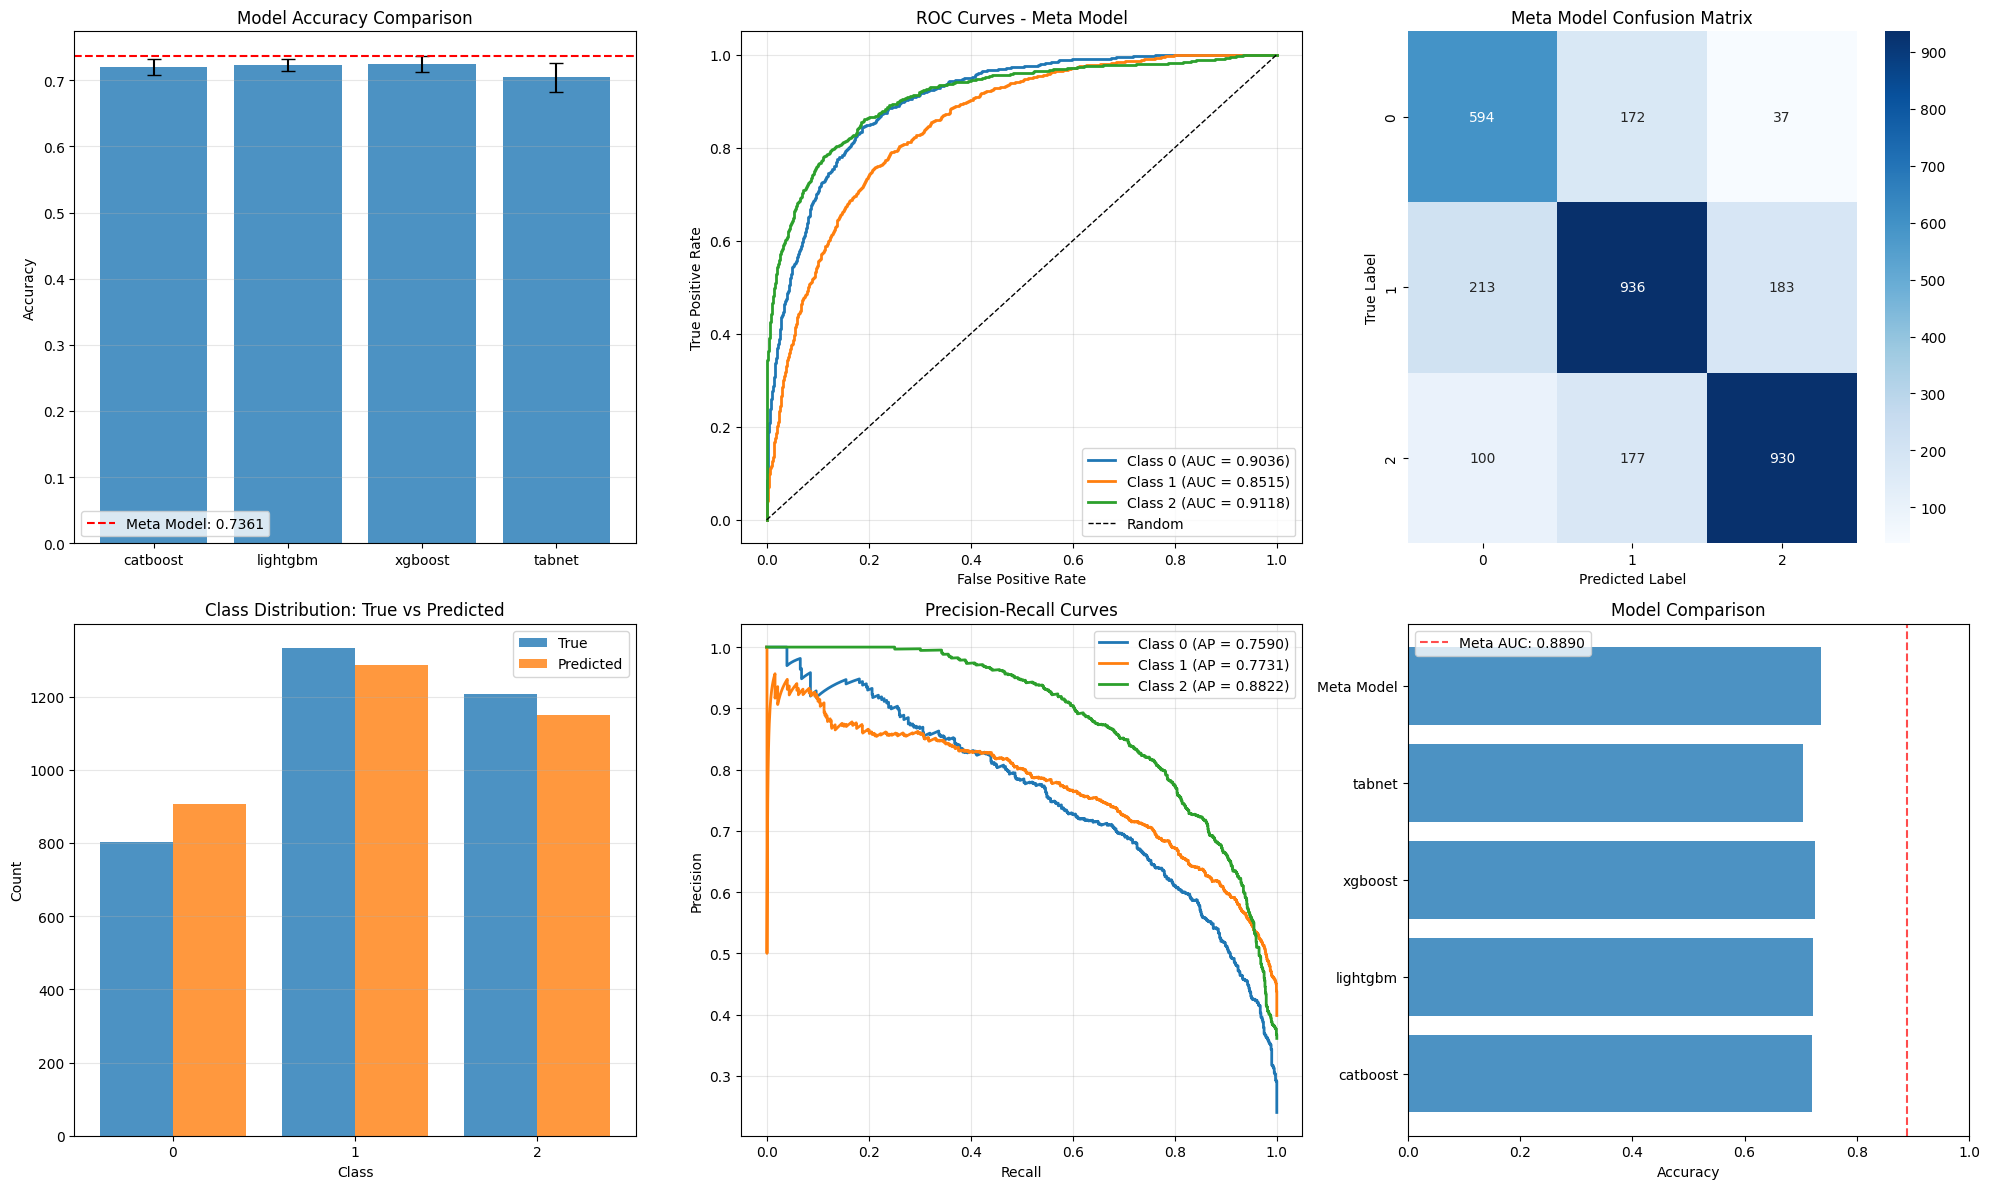


Computing SHAP values for Base Models on Original Features...


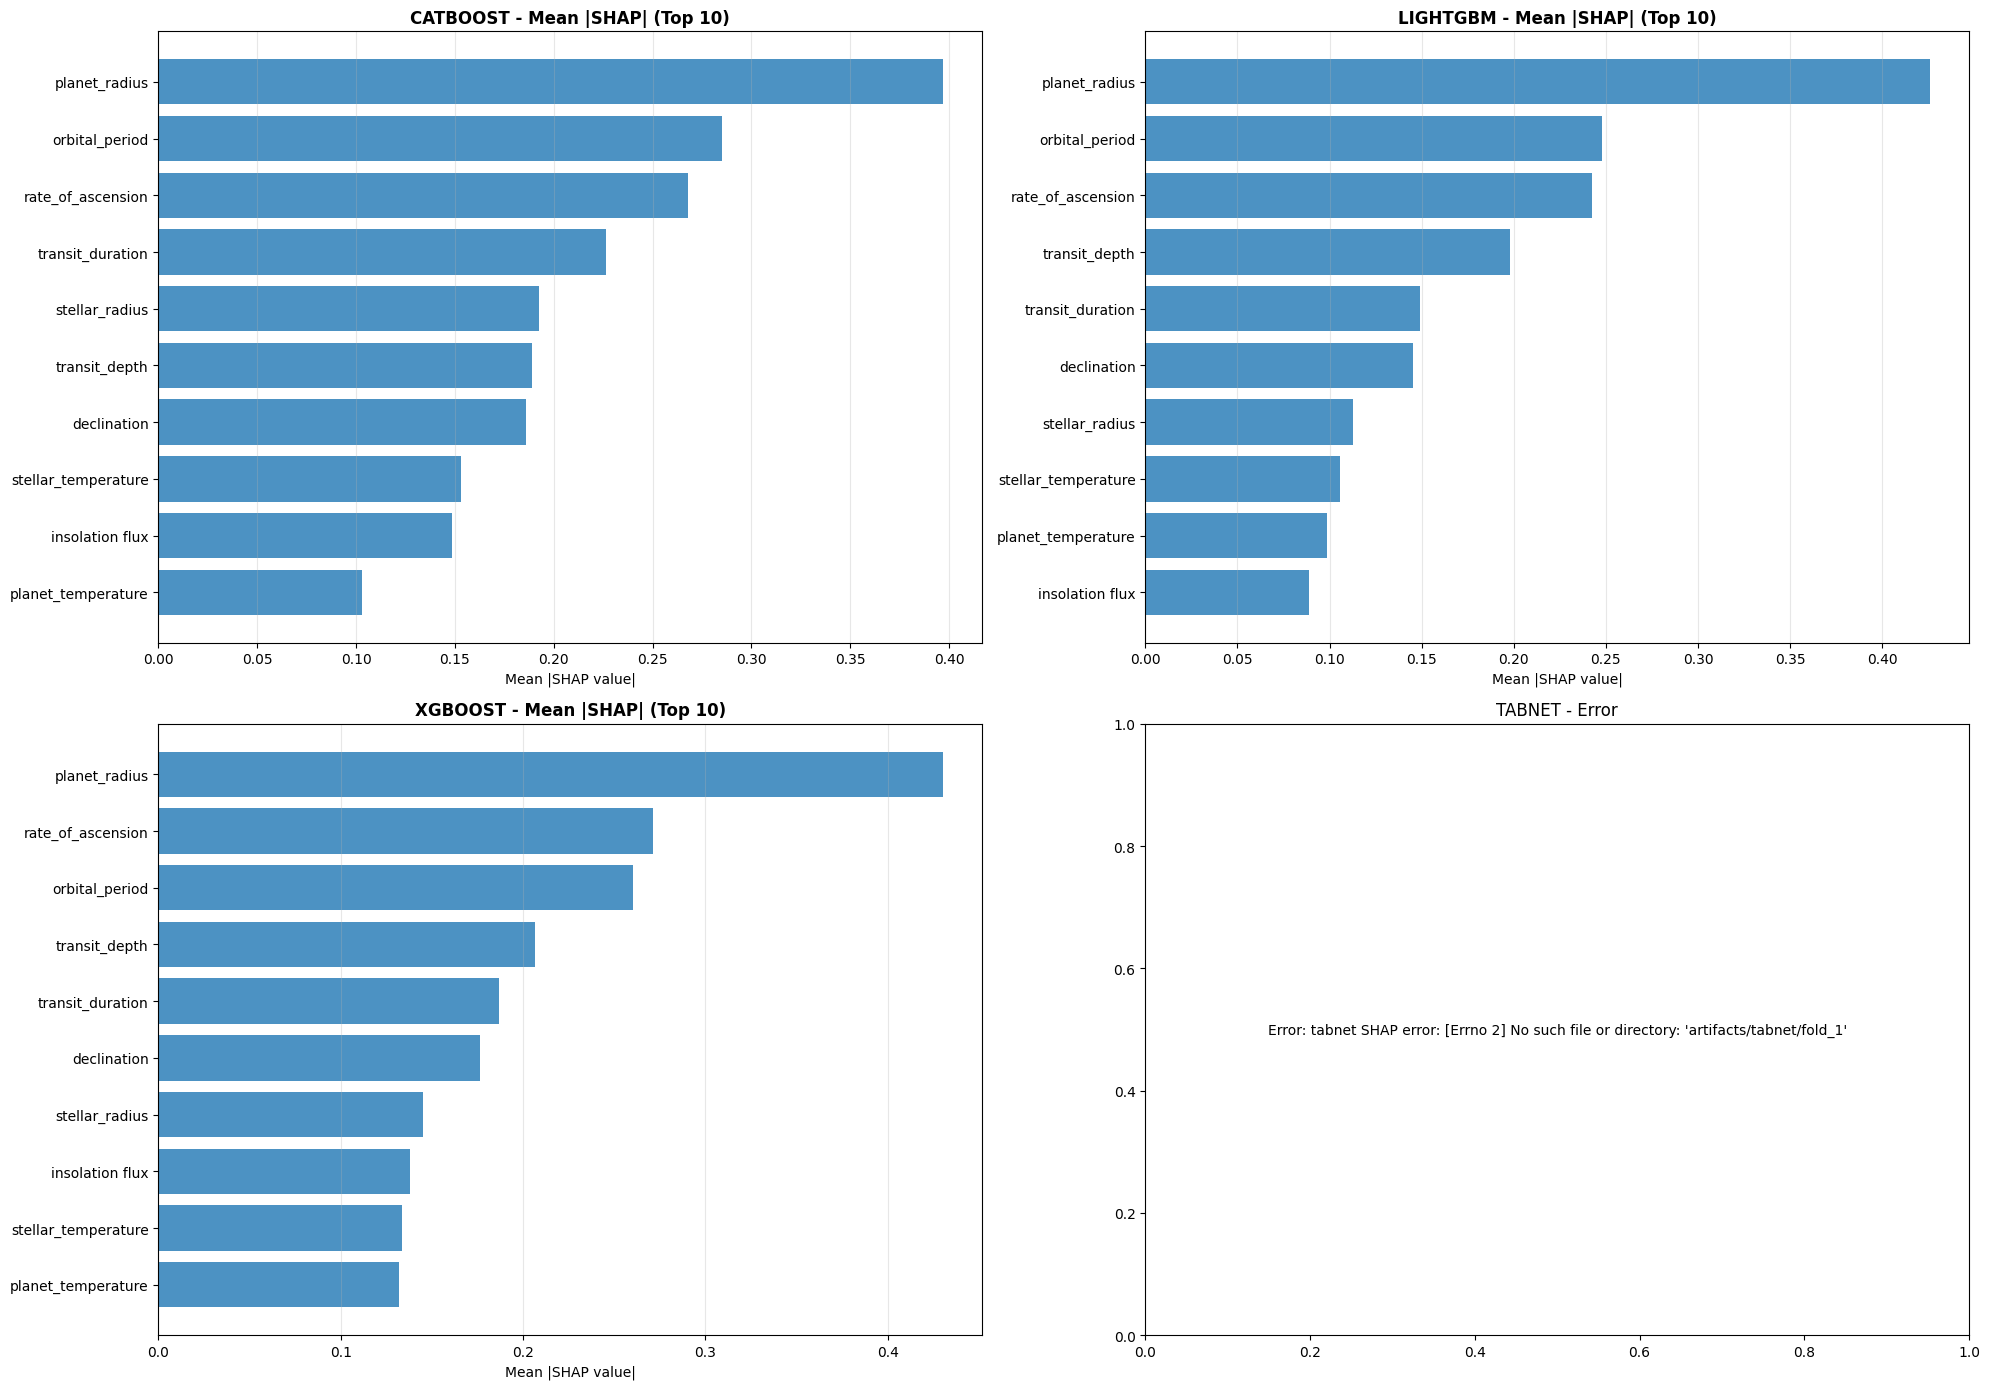


Generating detailed SHAP analysis for best model...


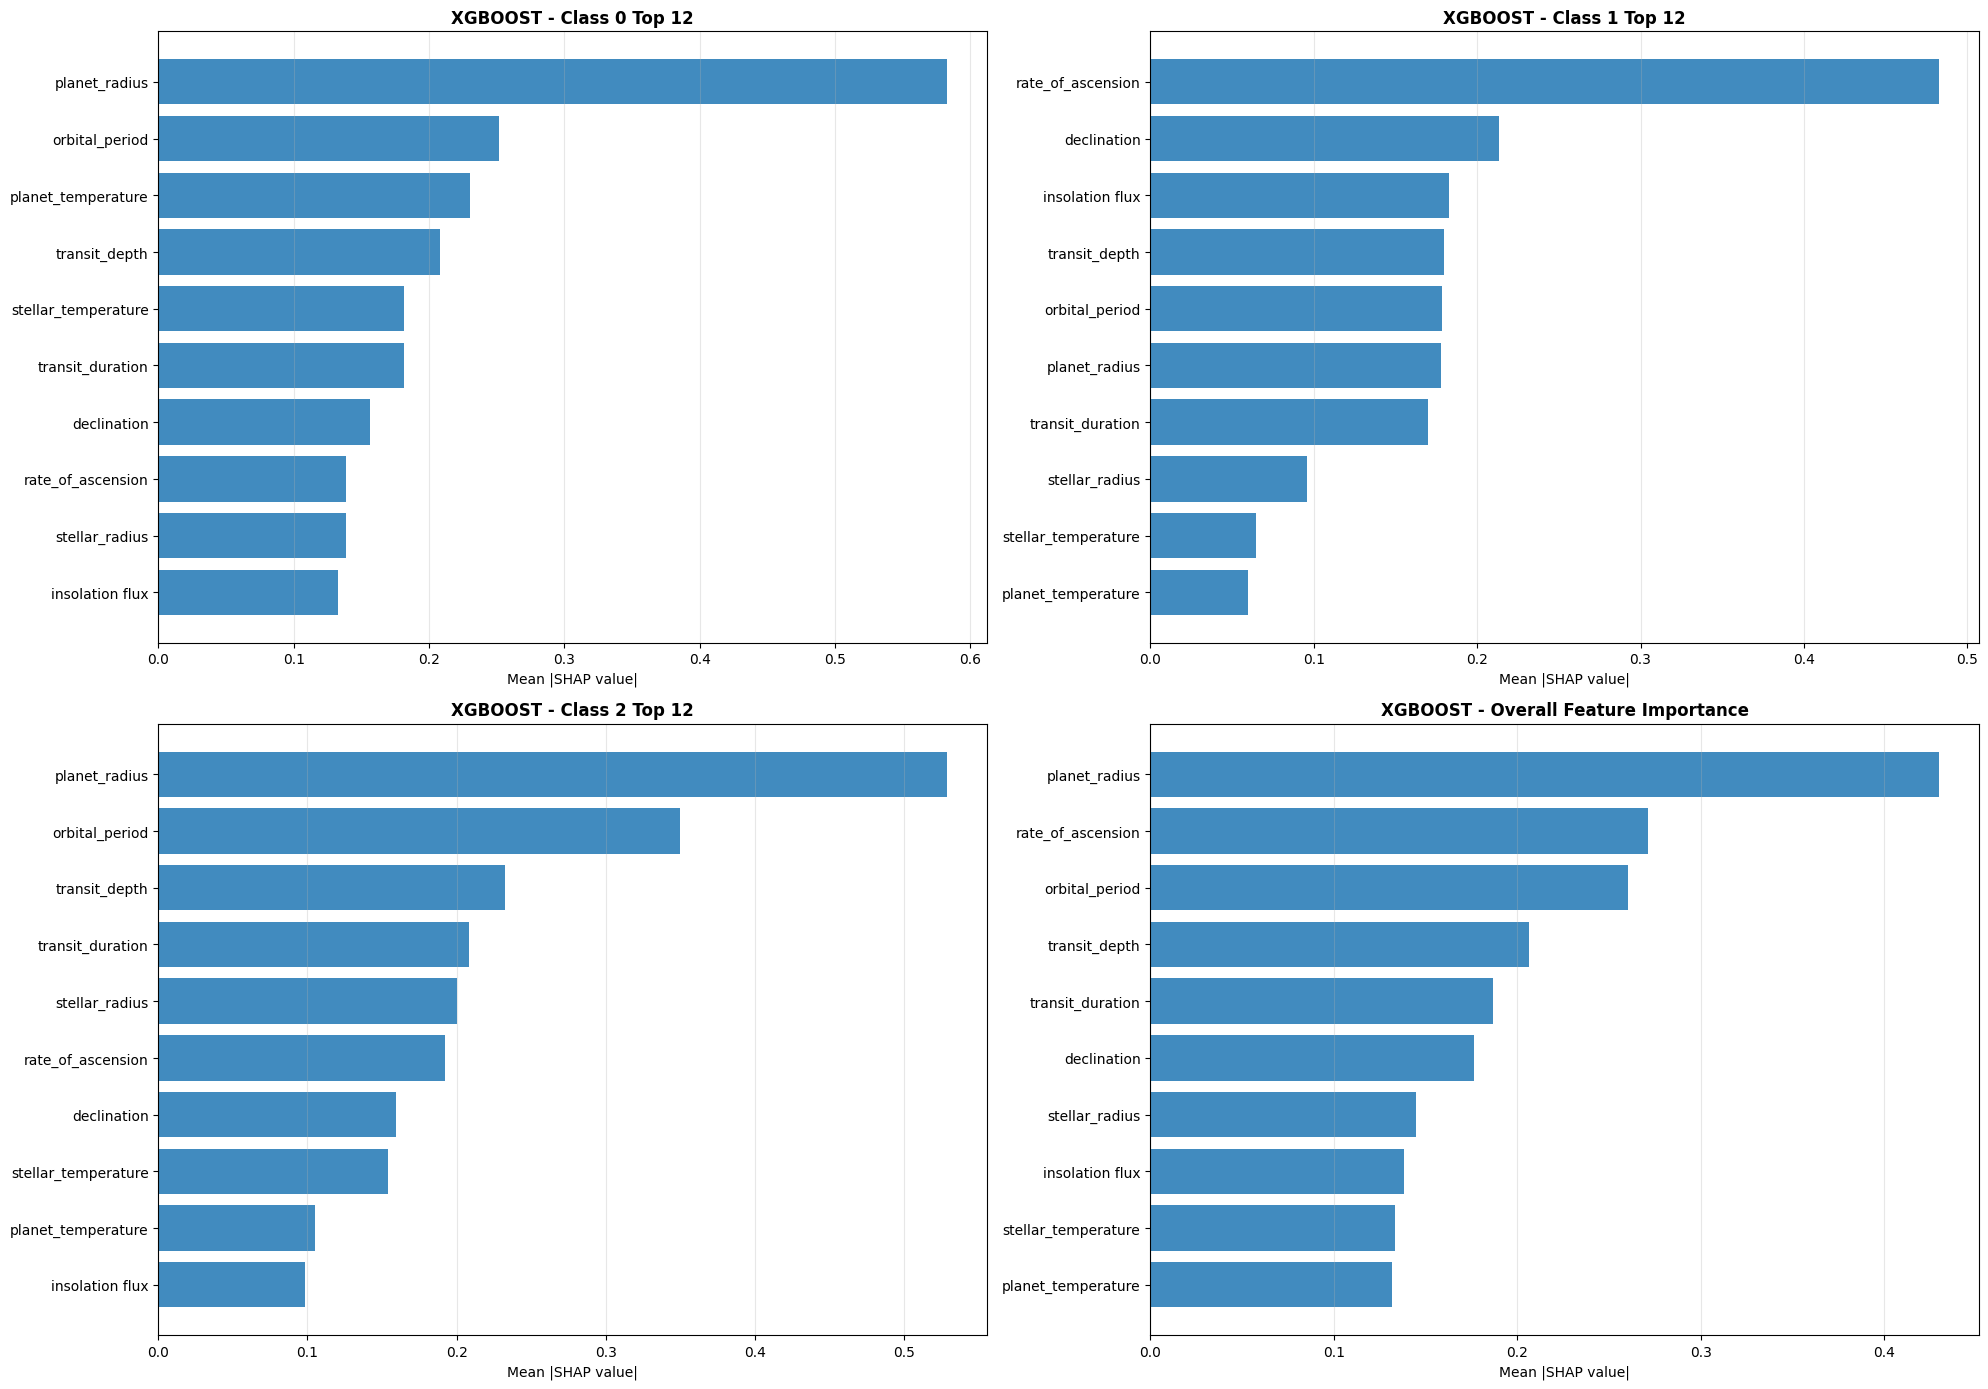


Generating SHAP dependence plots...


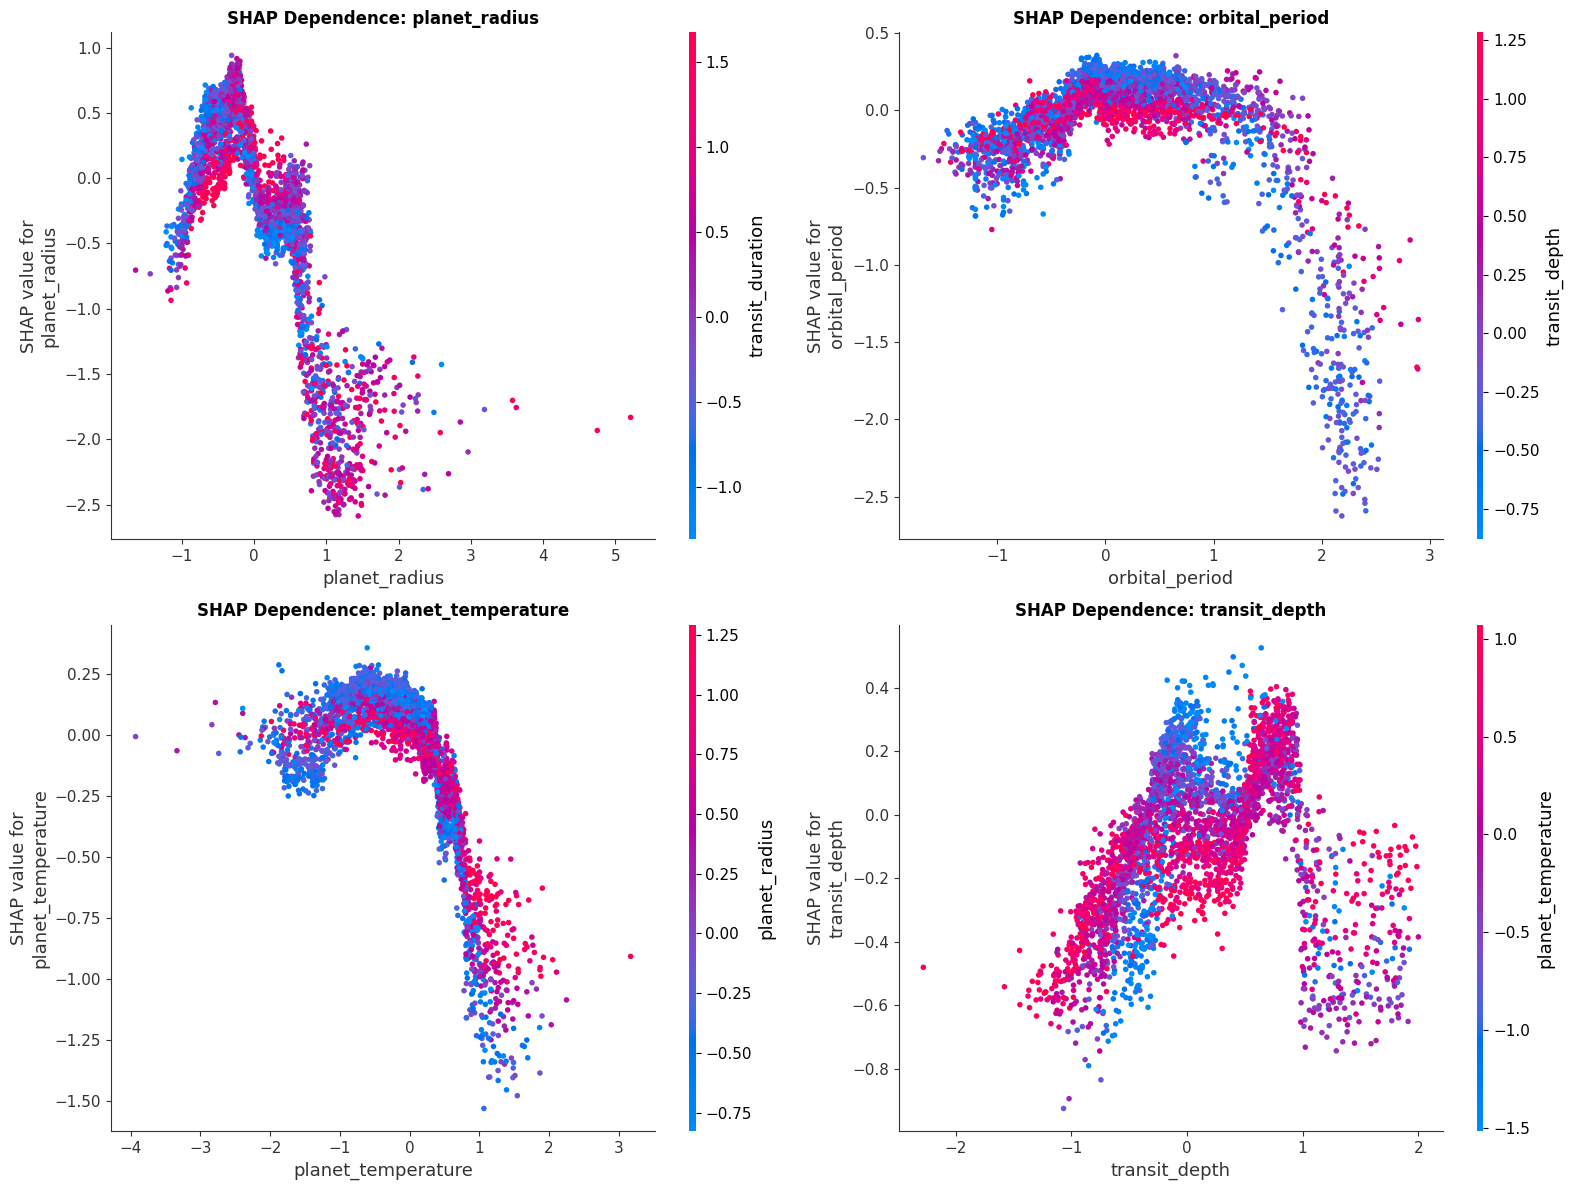


SUMMARY

Best Base Model: XGBOOST
  Accuracy: 0.7248

Meta Model Performance:
  Accuracy: 0.7361
  AUC-ROC:  0.8890
  Improvement over best base: +0.0113 (+1.13%)

Top 5 Most Important Features (from XGBOOST):
  planet_radius            : 0.4301
  rate_of_ascension        : 0.2713
  orbital_period           : 0.2603
  transit_depth            : 0.2067
  transit_duration         : 0.1866

All visualizations saved:
  - model_performance_with_auc.png (includes ROC & PR curves)
  - shap_original_features.png (bar charts -> guaranteed visible)
  - shap_best_model_detailed.png (bars; robust across libs)
  - shap_dependence_plots.png


In [ ]:
# ============================================================================
# FINAL VERIFICATION AND VISUALIZATION WITH AUC-ROC
# ============================================================================

import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import shap
import joblib

from sklearn.metrics import (
    confusion_matrix, roc_auc_score, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split

print("="*80)
print("STACKING ENSEMBLE - FINAL RESULTS (FIXED)")
print("="*80)

# ----------------------------
# Paths & constants
# ----------------------------
artifact_root = Path("artifacts")
artifact_root.mkdir(parents=True, exist_ok=True)

# ----------------------------
# Load original dataset
# ----------------------------
try:
    data_path = Path("/kaggle/input/nasa-dataset-tryhard/combined_imputed_values.csv")
    df = pd.read_csv(data_path)
except Exception as e:
    raise FileNotFoundError(
        f"Could not read dataset at {data_path}. Error: {e}"
    )

X = df.drop(columns=["disposition"])
y = df["disposition"]

# ----------------------------
# Label encoding & split (mirror training)
# ----------------------------
le = LabelEncoder()
y_fixed = le.fit_transform(y)

try:
    RANDOM_SEED  # may exist from previous cells
except NameError:
    RANDOM_SEED = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y_fixed, test_size=0.2, stratify=y_fixed, random_state=RANDOM_SEED
)

print(f"Test set shape: {X_test.shape}")
print(f"Test set classes: {np.unique(y_test)}\n")

# Ensure we always have a DataFrame for plotting labels later
X_test_for_plot = X_test.copy()

# ----------------------------
# Load predictions & meta probabilities
# ----------------------------
meta_test_proba_path = artifact_root / "meta_test_proba.npy"
predictions_csv_path = artifact_root / "meta_model_test_predictions.csv"

if not meta_test_proba_path.exists():
    raise FileNotFoundError(f"Missing file: {meta_test_proba_path}")
if not predictions_csv_path.exists():
    raise FileNotFoundError(f"Missing file: {predictions_csv_path}")

meta_test_proba = np.load(meta_test_proba_path)
predictions_df = pd.read_csv(predictions_csv_path)

# ----------------------------
# Check that pipeline_results exists
# ----------------------------
if 'pipeline_results' not in globals():
    raise RuntimeError("pipeline_results not found. Run training first before visualization.")

# ----------------------------
# AUC computation
# ----------------------------
num_classes = len(np.unique(predictions_df['y_true']))

if num_classes == 2:
    meta_auc = roc_auc_score(predictions_df['y_true'], meta_test_proba[:, 1])
    print(f"\nMeta Model AUC-ROC: {meta_auc:.4f}")
else:
    meta_auc = roc_auc_score(
        predictions_df['y_true'], meta_test_proba, multi_class='ovr', average='macro'
    )
    print(f"\nMeta Model AUC-ROC (macro): {meta_auc:.4f}")

# ----------------------------
# Display Meta Model Performance
# ----------------------------
print("\nMETA MODEL PERFORMANCE")
print("-"*80)

# At this point, we already guaranteed pipeline_results exists in memory
train_acc = pipeline_results.get('meta_train_accuracy', None)
test_acc = pipeline_results.get('meta_test_accuracy', None)

if train_acc is not None:
    print(f"Train Accuracy: {train_acc:.4f}")
if test_acc is not None:
    print(f"Test Accuracy:  {test_acc:.4f}")

print(f"Test AUC-ROC:   {meta_auc:.4f}")

cls_report = pipeline_results.get('classification_report', None)
if cls_report is not None:
    print(f"\nClassification Report:\n{cls_report}")
else:
    print("\nClassification Report not found in pipeline_results.")

# ----------------------------
# Display Base Model CV Performance
# ----------------------------
print("\nBASE MODEL CROSS-VALIDATION PERFORMANCE")
print("-"*80)
for model_name, metrics in pipeline_results['fold_metrics'].items():
    print(f"{model_name.upper():12s}: {metrics['mean_accuracy']:.4f} ± {metrics['std_accuracy']:.4f}")

print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

# ============================================================================
# FIGURE 1: PERFORMANCE VISUALIZATIONS WITH AUC
# ============================================================================
fig1, axes = plt.subplots(2, 3, figsize=(20, 12))

# Plot 1: Base Model vs Meta Model Accuracy
ax1 = axes[0, 0]
models = list(pipeline_results['fold_metrics'].keys())
means = [pipeline_results['fold_metrics'][m]['mean_accuracy'] for m in models]
stds = [pipeline_results['fold_metrics'][m]['std_accuracy'] for m in models]

ax1.bar(models, means, yerr=stds, capsize=5, alpha=0.8)
ax1.axhline(
    y=pipeline_results['meta_test_accuracy'],
    color='red', linestyle='--',
    label=f"Meta Model: {pipeline_results['meta_test_accuracy']:.4f}"
)
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy Comparison')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: ROC Curves
ax2 = axes[0, 1]
y_true = predictions_df['y_true'].values

if num_classes == 2:
    fpr, tpr, _ = roc_curve(y_true, meta_test_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    ax2.plot(fpr, tpr, lw=2, label=f'ROC (AUC = {roc_auc:.4f})')
else:
    y_true_bin = label_binarize(y_true, classes=range(num_classes))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], meta_test_proba[:, i])
        roc_auc = auc(fpr, tpr)
        ax2.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.4f})')

ax2.plot([0, 1], [0, 1], 'k--', lw=1, label='Random')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curves - Meta Model')
ax2.legend(loc='lower right')
ax2.grid(alpha=0.3)

# Plot 3: Confusion Matrix
ax3 = axes[0, 2]
cm = confusion_matrix(predictions_df['y_true'], predictions_df['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3)
ax3.set_title('Meta Model Confusion Matrix')
ax3.set_ylabel('True Label')
ax3.set_xlabel('Predicted Label')

# Plot 4: Prediction Distribution (side-by-side)
ax4 = axes[1, 0]
true_counts = predictions_df['y_true'].value_counts().sort_index()
pred_counts = predictions_df['y_pred'].value_counts().sort_index()
idx_all = sorted(set(true_counts.index).union(pred_counts.index))
true_vals = [true_counts.get(i, 0) for i in idx_all]
pred_vals = [pred_counts.get(i, 0) for i in idx_all]
x = np.arange(len(idx_all))
w = 0.4
ax4.bar(x - w/2, true_vals, width=w, alpha=0.8, label='True')
ax4.bar(x + w/2, pred_vals, width=w, alpha=0.8, label='Predicted')
ax4.set_xticks(x)
ax4.set_xticklabels(idx_all)
ax4.set_title('Class Distribution: True vs Predicted')
ax4.set_xlabel('Class')
ax4.set_ylabel('Count')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# Plot 5: Precision-Recall Curve
ax5 = axes[1, 1]
if num_classes == 2:
    precision, recall, _ = precision_recall_curve(y_true, meta_test_proba[:, 1])
    avg_precision = average_precision_score(y_true, meta_test_proba[:, 1])
    ax5.plot(recall, precision, lw=2, label=f'PR (AP = {avg_precision:.4f})')
else:
    y_true_bin = label_binarize(y_true, classes=range(num_classes))
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], meta_test_proba[:, i])
        avg_precision = average_precision_score(y_true_bin[:, i], meta_test_proba[:, i])
        ax5.plot(recall, precision, lw=2, label=f'Class {i} (AP = {avg_precision:.4f})')

ax5.set_xlabel('Recall')
ax5.set_ylabel('Precision')
ax5.set_title('Precision-Recall Curves')
ax5.legend(loc='best')
ax5.grid(alpha=0.3)

# Plot 6: Model Comparison
ax6 = axes[1, 2]
all_accuracies = means + [pipeline_results['meta_test_accuracy']]
all_labels = models + ['Meta Model']
ax6.barh(all_labels, all_accuracies, alpha=0.8)
ax6.set_xlabel('Accuracy')
ax6.set_title('Model Comparison')
ax6.set_xlim(0, 1)
ax6.axvline(x=meta_auc, color='red', linestyle='--', alpha=0.7, label=f'Meta AUC: {meta_auc:.4f}')
ax6.legend()

plt.tight_layout()
plt.savefig(artifact_root / 'model_performance_with_auc.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================================
# FIGURE 2: SHAP ANALYSIS - BASE MODELS WITH ORIGINAL FEATURES (RENDER-ON-AXES)
# ============================================================================
print("\nComputing SHAP values for Base Models on Original Features...")

fig2, axes = plt.subplots(2, 2, figsize=(20, 14))
axes = axes.flatten()

base_models_config = [
    ('catboost', 'cbm'),
    ('lightgbm', 'txt'),
    ('xgboost', 'json'),
    ('tabnet',  'zip'),   # you noted folds are .zip for TabNet
]
fold_num = 1

# Helper to compute SHAP values safely and return mean|SHAP| vector and feature names
def safe_shap_importances(model_name, ext, fold_num, X_for_explain: pd.DataFrame):
    X_local = X_for_explain.copy()
    feature_names = list(X_local.columns)

    try:
        if model_name == 'catboost':
            from catboost import CatBoostClassifier
            model_path = artifact_root / f"{model_name}/fold_{fold_num}.{ext}"
            model = CatBoostClassifier()
            model.load_model(str(model_path))
            explainer = shap.TreeExplainer(model)
            sv = explainer.shap_values(X_local)
            # CatBoost returns list for multiclass
            if isinstance(sv, list):
                mean_abs = np.mean([np.abs(s).mean(0) for s in sv], axis=0)
            else:
                mean_abs = np.abs(sv).mean(0)

        elif model_name == 'lightgbm':
            import lightgbm as lgb
            model_path = artifact_root / f"{model_name}/fold_{fold_num}.{ext}"
            model = lgb.Booster(model_file=str(model_path))
            explainer = shap.TreeExplainer(model)
            sv = explainer.shap_values(X_local)
            if isinstance(sv, list):
                mean_abs = np.mean([np.abs(s).mean(0) for s in sv], axis=0)
            else:
                mean_abs = np.abs(sv).mean(0)

        elif model_name == 'xgboost':
            import xgboost as xgb
            model_path = artifact_root / f"{model_name}/fold_{fold_num}.{ext}"
            model = xgb.XGBClassifier()
            model.load_model(str(model_path))

            # Avoid SHAP reshape error (#580) by using the booster and numpy array
            booster = model.get_booster()
            explainer = shap.TreeExplainer(booster)
            X_np = X_local.values  # ensure ndarray
            sv = explainer.shap_values(X_np)
            if isinstance(sv, list):
                mean_abs = np.mean([np.abs(s).mean(0) for s in sv], axis=0)
            else:
                mean_abs = np.abs(sv).mean(0)

        elif model_name == 'tabnet':
            from pytorch_tabnet.tab_model import TabNetClassifier
            model_prefix = str(artifact_root / f"{model_name}/fold_{fold_num}")
            model = TabNetClassifier()
            # TabNet saves as "<prefix>.zip"
            model.load_model(model_prefix)
            def model_predict(data):
                return model.predict_proba(data)

            # Use a small background to keep runtime reasonable
            background = shap.sample(X_local, min(100, len(X_local)))
            explainer = shap.KernelExplainer(model_predict, background)
            # Compute on subset for speed
            sample_size = min(300, len(X_local))
            X_sub = X_local.iloc[:sample_size]
            sv = explainer.shap_values(X_sub)
            # Return importances aligned to full feature set (using the subset)
            if isinstance(sv, list):
                mean_abs = np.mean([np.abs(s).mean(0) for s in sv], axis=0)
            else:
                mean_abs = np.abs(sv).mean(0)
            # Align feature names to subset used for SHAP dependence if needed
            return mean_abs, feature_names, X_sub, sv

        else:
            raise ValueError(f"Unknown model: {model_name}")

        return mean_abs, feature_names, X_local, sv

    except Exception as e:
        raise RuntimeError(f"{model_name} SHAP error: {e}")

# We will also keep references for dependence plots
best_model_name = max(pipeline_results['fold_metrics'].items(),
                      key=lambda x: x[1]['mean_accuracy'])[0]
last_sv = None
X_used_for_best = X_test_for_plot

for idx, (model_name, ext) in enumerate(base_models_config):
    ax = axes[idx]
    try:
        mean_abs, feat_names, X_used, sv = safe_shap_importances(model_name, ext, fold_num, X_test_for_plot)
        # Plot top 10 features as bar chart (ensures content in our axes)
        top_k = 10
        order = np.argsort(mean_abs)[-top_k:]
        ax.barh([feat_names[i] for i in order], [mean_abs[i] for i in order], alpha=0.8)
        ax.set_title(f'{model_name.upper()} - Mean |SHAP| (Top {top_k})', fontsize=12, fontweight='bold')
        ax.set_xlabel('Mean |SHAP value|')
        ax.grid(axis='x', alpha=0.3)

        if model_name == best_model_name:
            last_sv = sv
            X_used_for_best = X_used

    except Exception as e:
        ax.text(0.5, 0.5, f'Error: {str(e)[:120]}', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{model_name.upper()} - Error', fontsize=12)

plt.tight_layout()
plt.savefig(artifact_root / 'shap_original_features.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================================
# FIGURE 3: DETAILED SHAP FOR BEST MODEL (ROBUST)
# ============================================================================
print("\nGenerating detailed SHAP analysis for best model...")

fig3, axes = plt.subplots(2, 2, figsize=(20, 14))
axes = axes.flatten()

try:
    # Prepare SHAP values again for the best model with safe function
    mean_abs, feat_names, X_used_for_best, sv = safe_shap_importances(
        best_model_name,
        {'catboost':'cbm','lightgbm':'txt','xgboost':'json','tabnet':'zip'}[best_model_name],
        1,
        X_test_for_plot
    )

    # If SHAP returns list (multiclass), build combined importance and 3 class plots; else single
    if isinstance(sv, list):
        # 0-2 classes (or up to available)
        classes_to_show = min(3, len(sv))
        for class_idx in range(classes_to_show):
            ax = axes[class_idx]
            # Build mean|SHAP| and plot bar chart for this class
            class_imp = np.abs(sv[class_idx]).mean(0)
            order = np.argsort(class_imp)[-12:]
            ax.barh([feat_names[i] for i in order], [class_imp[i] for i in order], alpha=0.85)
            ax.set_title(f'{best_model_name.upper()} - Class {class_idx} Top 12', fontsize=12, fontweight='bold')
            ax.set_xlabel('Mean |SHAP value|')
            ax.grid(axis='x', alpha=0.3)

        # Overall importance
        ax = axes[3]
        overall = np.mean([np.abs(s).mean(0) for s in sv], axis=0)
        order = np.argsort(overall)[-15:]
        ax.barh([feat_names[i] for i in order], [overall[i] for i in order], alpha=0.85)
        ax.set_title(f'{best_model_name.upper()} - Overall Feature Importance', fontweight='bold')
        ax.set_xlabel('Mean |SHAP value|')
        ax.grid(axis='x', alpha=0.3)

    else:
        # Binary/regression-like SHAP array
        ax = axes[0]
        order = np.argsort(np.abs(sv).mean(0))[-15:]
        ax.barh([feat_names[i] for i in order], [np.abs(sv).mean(0)[i] for i in order], alpha=0.85)
        ax.set_title(f'{best_model_name.upper()} - SHAP Summary (Top 15)', fontsize=12, fontweight='bold')
        ax.set_xlabel('Mean |SHAP value|')
        ax.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.savefig(artifact_root / 'shap_best_model_detailed.png', dpi=150, bbox_inches='tight')
    plt.show()

except Exception as e:
    print(f"Error generating SHAP for {best_model_name}: {str(e)}")
    print("Skipping detailed SHAP analysis for best model...")

# ============================================================================
# FIGURE 4: SHAP DEPENDENCE PLOTS (RESILIENT)
# ============================================================================
print("\nGenerating SHAP dependence plots...")

try:
    # Build a single matrix of SHAP values to select top features
    if 'sv' in locals() and sv is not None:
        if isinstance(sv, list):
            shap_vals_for_top = sv[0]  # use first class for top feature selection
        else:
            shap_vals_for_top = sv
    else:
        raise RuntimeError("No SHAP values available from previous step to create dependence plots.")

    # Ensure we have a consistent X frame for plotting
    if isinstance(X_used_for_best, pd.DataFrame):
        X_dep = X_used_for_best
    else:
        X_dep = X_test_for_plot

    mean_abs_shap = np.abs(shap_vals_for_top).mean(0)
    top_features_idx = np.argsort(mean_abs_shap)[-4:][::-1]

    fig4, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for idx, feat_idx in enumerate(top_features_idx):
        try:
            feature_name = X_dep.columns[feat_idx] if hasattr(X_dep, 'columns') else feat_idx
            shap.dependence_plot(feat_idx, shap_vals_for_top, X_dep, ax=axes[idx], show=False)
            axes[idx].set_title(f'SHAP Dependence: {feature_name}', fontsize=12, fontweight='bold')
        except Exception as inner_e:
            axes[idx].text(0.5, 0.5, f'Error: {str(inner_e)[:120]}', ha='center', va='center', transform=axes[idx].transAxes)
            axes[idx].set_title(f'Dependence Error: {feature_name}', fontsize=12)


    plt.tight_layout()
    plt.savefig(artifact_root / 'shap_dependence_plots.png', dpi=150, bbox_inches='tight')
    plt.show()

except Exception as e:
    print(f"Error generating dependence plots: {str(e)}")

# ============================================================================
# SUMMARY WITH AUC
# ============================================================================
print("\n" + "="*80)
print("SUMMARY")
print("="*80)

best_model_name = max(pipeline_results['fold_metrics'].items(),
                      key=lambda x: x[1]['mean_accuracy'])[0]
print(f"\nBest Base Model: {best_model_name.upper()}")
print(f"  Accuracy: {pipeline_results['fold_metrics'][best_model_name]['mean_accuracy']:.4f}")

improvement_acc = pipeline_results['meta_test_accuracy'] - pipeline_results['fold_metrics'][best_model_name]['mean_accuracy']
print(f"\nMeta Model Performance:")
print(f"  Accuracy: {pipeline_results['meta_test_accuracy']:.4f}")
print(f"  AUC-ROC:  {meta_auc:.4f}")
print(f"  Improvement over best base: {improvement_acc:+.4f} ({improvement_acc*100:+.2f}%)")

# If we have overall feature importance from detailed SHAP, print top 5
try:
    if 'sv' in locals() and sv is not None:
        if isinstance(sv, list):
            overall = np.mean([np.abs(s).mean(0) for s in sv], axis=0)
        else:
            overall = np.abs(sv).mean(0)

        feat_names = X_used_for_best.columns if isinstance(X_used_for_best, pd.DataFrame) else [f"f{i}" for i in range(len(overall))]
        top_idx = np.argsort(overall)[-5:][::-1]
        print(f"\nTop 5 Most Important Features (from {best_model_name.upper()}):")
        for i in top_idx:
            print(f"  {feat_names[i]:25s}: {overall[i]:.4f}")
except Exception:
    pass

print("\n" + "="*80)
print("All visualizations saved:")
print("  - model_performance_with_auc.png (includes ROC & PR curves)")
print("  - shap_original_features.png (bar charts -> guaranteed visible)")
print("  - shap_best_model_detailed.png (bars; robust across libs)")
print("  - shap_dependence_plots.png")
print("="*80)


In [ ]:
import shutil

shutil.make_archive('artifacts', 'zip', '/kaggle/working/artifacts')

from IPython.display import FileLink
FileLink(r'artifacts.zip')

/kaggle/working/artifacts.zip